In [8]:
REPO = '../'
RESULT_TABLE = f'{REPO}/data/table'
RESULT_OBJ = f'{REPO}/data/object'
FIGURE_FOLDER= f'{REPO}/data/figure'
SETTING_FOLDER = f'{REPO}/data/setting'
EXTERNAL_DATA=f'{REPO}/data/external'

import sys
sys.path.append(REPO)
from settings import COLOR_PAlETTE
from utils.visual import *
from utils.statsTest import lmTest

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scPipe as sp
import scanpy as sc
import seaborn as sns
import warnings
import commentjson

### Additional Colormap
with open(f'{SETTING_FOLDER}/ColorMap.json','r') as f:
    colormap = commentjson.load(f)
COLOR_PAlETTE.update(colormap)
plt.style.use(f'{REPO}/paper.mplstyle')
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
obs_path = f'{RESULT_TABLE}/GEX_OBS_Lineage.csv'
## Load data
adata = sc.read(f'{RESULT_OBJ}/gex_all.h5ad')
obs = pd.read_csv(obs_path,index_col=0)
adata = adata[adata.obs.index.isin(obs.index[obs.Lineage=='Myeloid']),:].copy()
adata.obs['scSHC' ]=pd.read_csv(f"{RESULT_TABLE}/scSHC/Myeloid_clusters.csv",index_col=0)['x'].astype(str)
print(f'{adata.obs.shape[0]:,} Myeloid cells')

15,953 Myeloid cells


# GEX log1p Normalization

In [10]:
sp.utils.log1pNorm(adata)

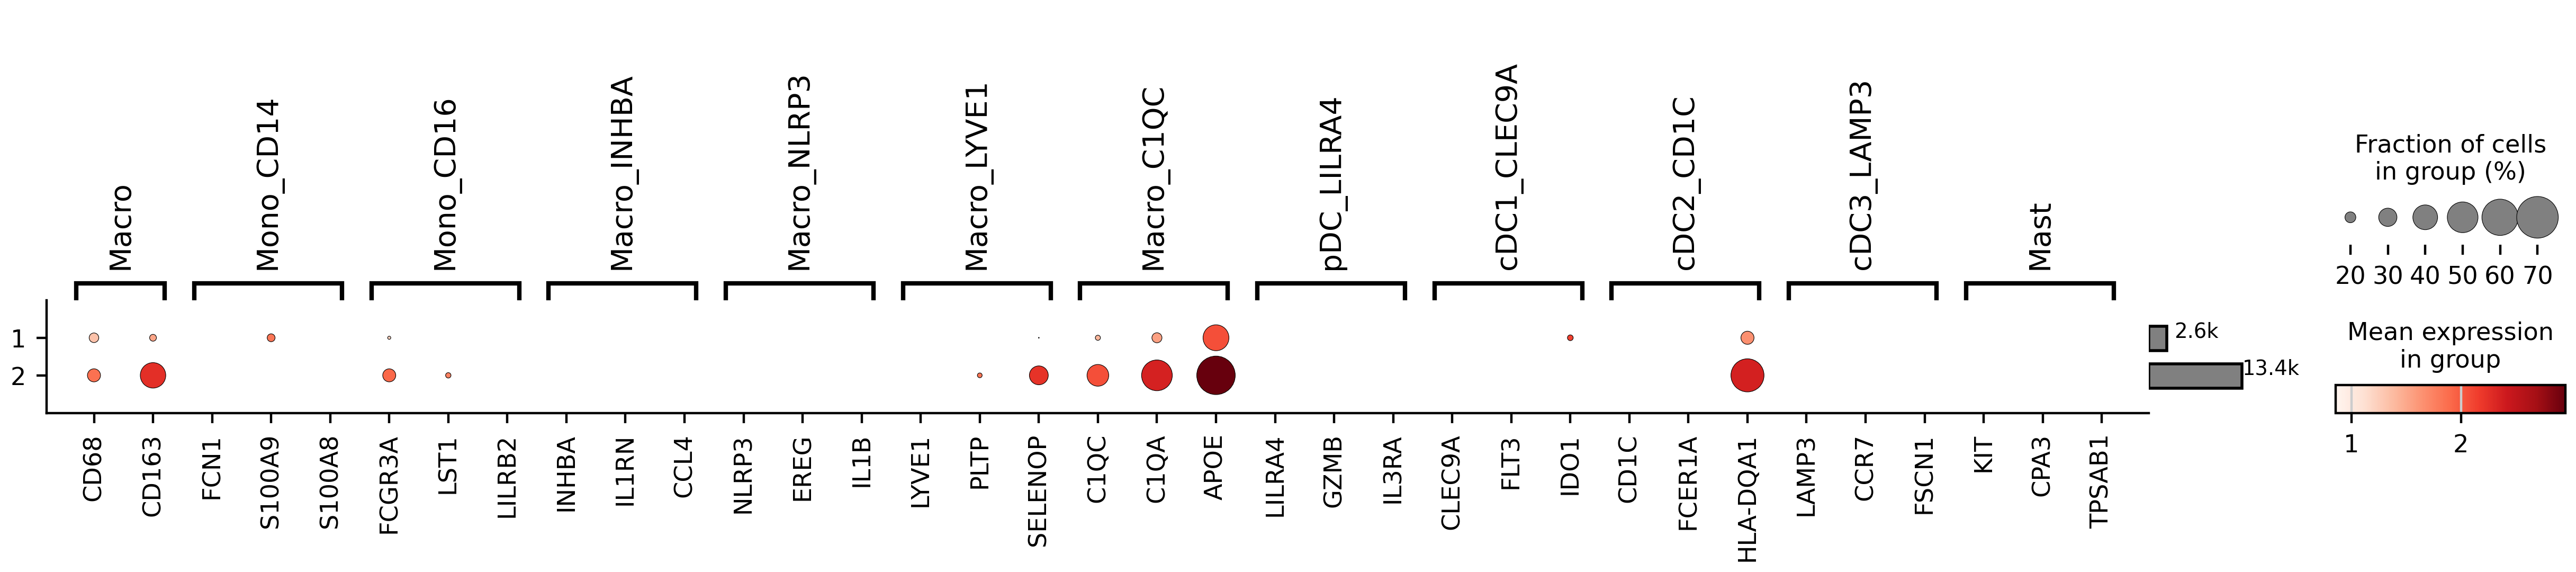

In [11]:
markers = {
    "Macro":['CD68','CD163'],
    "Mono_CD14":['FCN1','S100A9','S100A8'],
    "Mono_CD16":['FCGR3A','LST1','LILRB2'],
    "Macro_INHBA":['INHBA','IL1RN','CCL4'],
    "Macro_NLRP3":['NLRP3','EREG','IL1B'],
    "Macro_LYVE1":['LYVE1','PLTP','SELENOP'],
    "Macro_C1QC":['C1QC','C1QA','APOE'],
    "pDC_LILRA4":['LILRA4','GZMB','IL3RA'],
    "cDC1_CLEC9A":['CLEC9A','FLT3','IDO1'],
    "cDC2_CD1C":['CD1C','FCER1A','HLA-DQA1'],
    "cDC3_LAMP3":['LAMP3','CCR7','FSCN1'],
    "Mast":['KIT','CPA3','TPSAB1']
}
sc.settings.set_figure_params(dpi=200,fontsize=10)
dp=sc.pl.dotplot(
    adata,
    var_names=markers,
    groupby='scSHC',
    mean_only_expressed=True,
    return_fig=True,
)
dp.add_totals(color='gray').style(dot_edge_color='black',cmap='Reds',dot_min=.1)
dp.show()

In [12]:
adata.obs['Celltype'] = adata.obs['scSHC'].map({
    '1':'Myeloid',
    '2':'Macs'
})
adata.obs[['Celltype']].to_csv(f"{RESULT_TABLE}/annotation/Myeloid.csv")
adata.obs['Celltype'].value_counts()

Macs       13375
Myeloid     2578
Name: Celltype, dtype: int64

# Cellstates idenfification of Macs using sNMF

- see Suppl Figure4


# Load Macs cellstate annotation

In [31]:
adata = sc.read(f'{RESULT_OBJ}/gex_all.h5ad')
obs = pd.read_csv(f"{RESULT_TABLE}/MPs/Macs/Annotation.csv",index_col=0)
sample_meta = pd.read_excel(f'{RESULT_TABLE}/Supplementary Table 1.xlsx',index_col=0).replace(np.nan,'N/A')

adata = adata[adata.obs.index.isin(obs.index),:]
adata.obs['Cellstate'] = obs.loc[adata.obs.index,'Cellstate']
adata.obs = adata.obs.merge(sample_meta,left_on='Sample',right_on='CCG_ID')
print(f'{adata.obs.shape[0]:,} Macrophages cells')
adata.obs['Cellstate'].value_counts()

13,375 Macrophages cells


Macs.Lipid          5291
Macs.Adhesion       2637
Macs.Endocytosis    2519
Macs.Interferon     1764
Macs.Secretion      1164
Name: Cellstate, dtype: int64

## Normalization - normalize_total

In [33]:
sc.pp.normalize_total(adata, target_sum=1e4)

# Heatmap visualization on genes in each MPs

## Load MPs geneset

In [34]:
mp_anno_path = f'{RESULT_TABLE}/MPs/Macs/MetaProgram_Annotation.csv'
mp_gmt_path = f'{RESULT_TABLE}/MPs/Macs/MP_Programs.gmt'
ref_ITH=pd.read_table(mp_gmt_path,header=None,index_col=0).drop([1],axis=1).T
anno = pd.read_csv(mp_anno_path,index_col=0)
MP_anno_map = anno[['MetaProgram','MPs']].drop_duplicates().set_index('MetaProgram')['MPs'].to_dict()
ref_ITH.columns = ref_ITH.columns.map(MP_anno_map)
ref_ITH=ref_ITH.melt()
ref_ITH.columns = ['Program','gene']
ref_ITH = ref_ITH.drop_duplicates(subset=['gene'],keep=False).set_index('gene')

## Visualize MPs in heatmap

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 21.986500000000003 mm


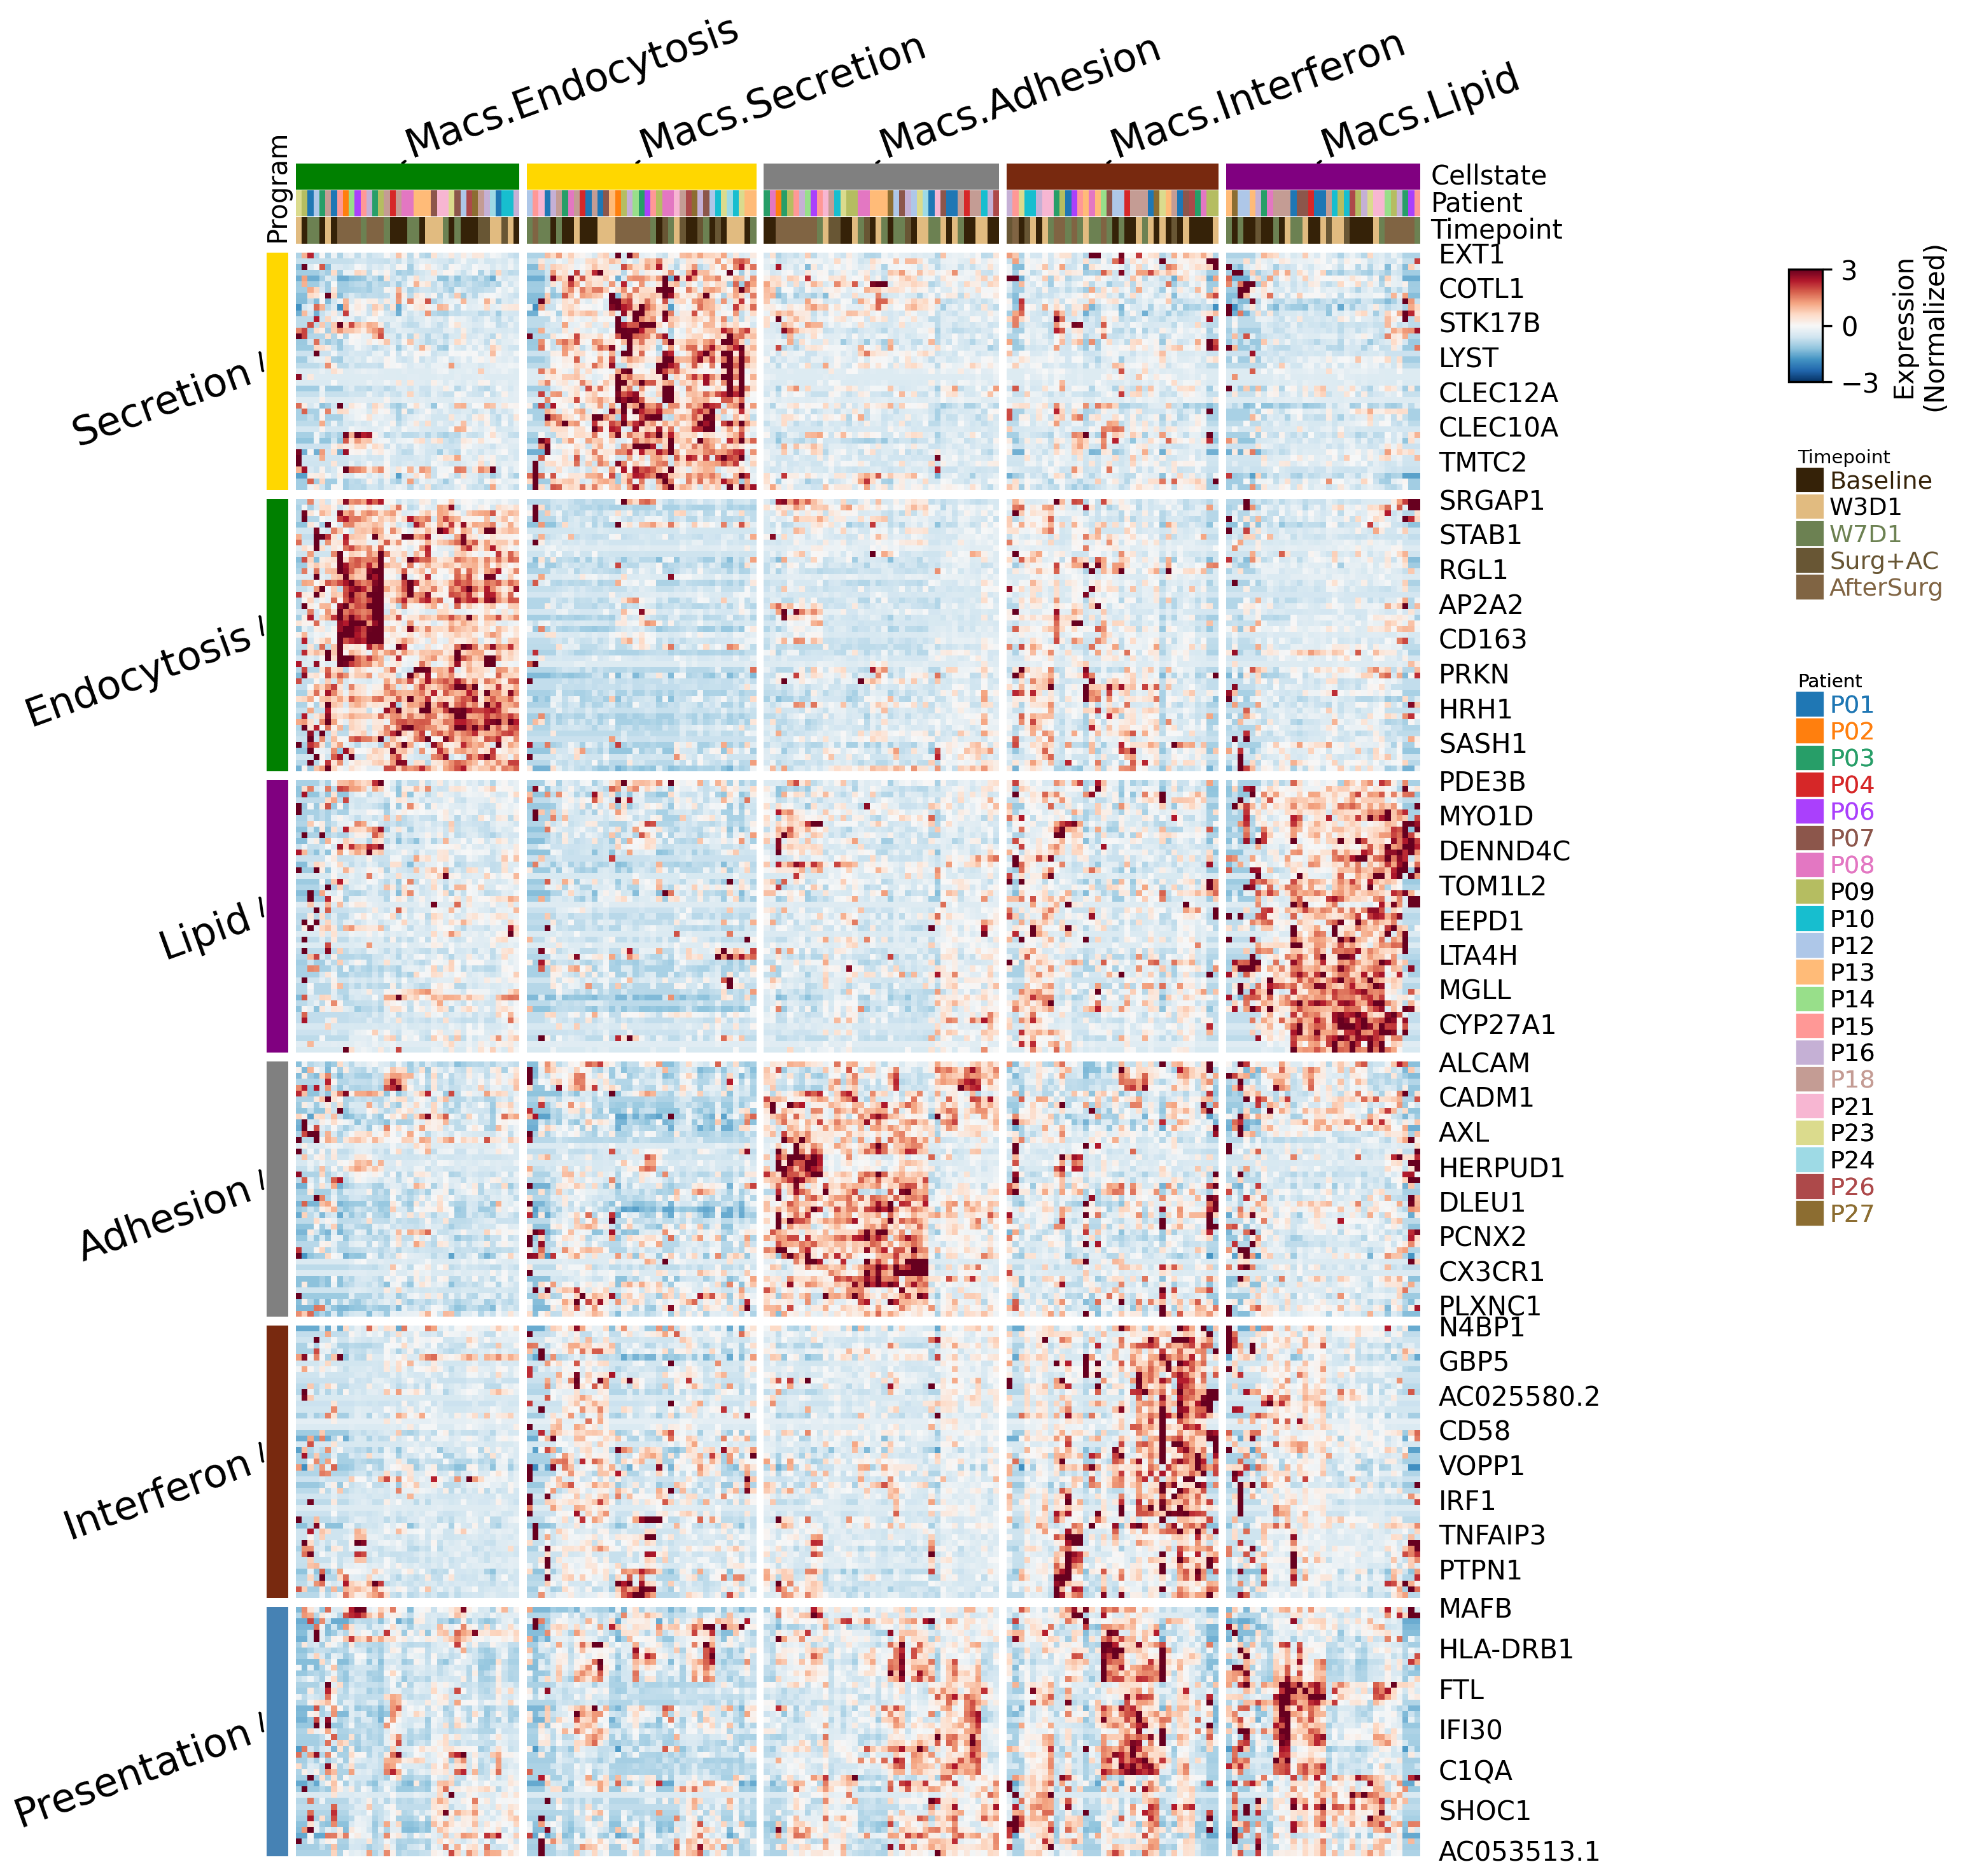

In [35]:
CELLTYPE='Macs'
palette={}
palette['Program'] = {k.replace(f'{CELLTYPE}.',''):v for k,v in COLOR_PAlETTE['Cellstate'].items() if CELLTYPE in k}
for c in ['Cellstate','Patient','Timepoint']:
    palette[c] = COLOR_PAlETTE[c]

aggregate_heatmap(adata=adata,
                  features=ref_ITH,
                  top_anno_columns=['Cellstate','Patient','Timepoint'],
                  col_split='Cellstate',
                  col_split_gap=1,
                  row_split='Program',
                  row_split_gap=1,
                  palette=palette,
                  figsize=(8,10),
                  vmin=-3,
                  vmax=3,
                  standard_normalization=True,
                  cbar_label='Expression\n(Normalized)',
                  cmap='RdBu_r'
                 )

# Score association

In [36]:
anno = pd.read_csv(f'{RESULT_TABLE}/MPs/Macs/MetaProgram_Annotation.csv',index_col=0)
MP_anno_map = anno[['MetaProgram','MPs']].drop_duplicates().set_index('MetaProgram')['MPs'].to_dict()
# get MP sores on all cells 
scores = pd.read_csv(f'{RESULT_TABLE}/MPs/Macs/signature_scores.csv',index_col=0)
# scores.columns = scores.map(MP_anno_map)
scores['CCG_ID'] =  scores.index.map(lambda x:'CCG1112'+x.split('CCG1112')[1][:-1])
# attach clinical information
sample_meta = pd.read_excel(f'{RESULT_TABLE}/Supplementary Table 1.xlsx',index_col=0).replace(np.nan,'N/A')
scores = scores.merge(sample_meta,on='CCG_ID',how='left')
scores['BestResponse'] = pd.Categorical(scores.BestResponse,['favorable response\n(RCB 0-I)','unfavorable response\n(RCB II-III)'],ordered=True)

## MPs pairwise correlation

In [37]:
for x in scores.columns[scores.columns.str.startswith('MP')]:
    adata.obs[MP_anno_map[x]]= scores[x]

In [38]:
order = ['Endocytosis','Lipid','Secretion','Adhesion','Presentation','Interferon']
dt =  adata.obs[order]
pvalues = []
for c in dt:
    p = dt.apply(lambda a: scipy.stats.pearsonr(a.values,dt[c].values)[1])
    p.name= c
    pvalues.append(p)
pvalues = pd.concat(pvalues,axis=1)
corr =  dt.corr()

In [39]:
data = corr.unstack().rename('Correlation').to_frame()
data['pvalue'] = pvalues.unstack()
data['Significance'] = 'N.S'
data.loc[data['pvalue']<0.01,'Significance'] = 'p<0.01'

data = data.reset_index().drop_duplicates(['pvalue','Correlation'])
data = data.loc[data.level_0!=data.level_1,:]

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 28.315333333333335 mm


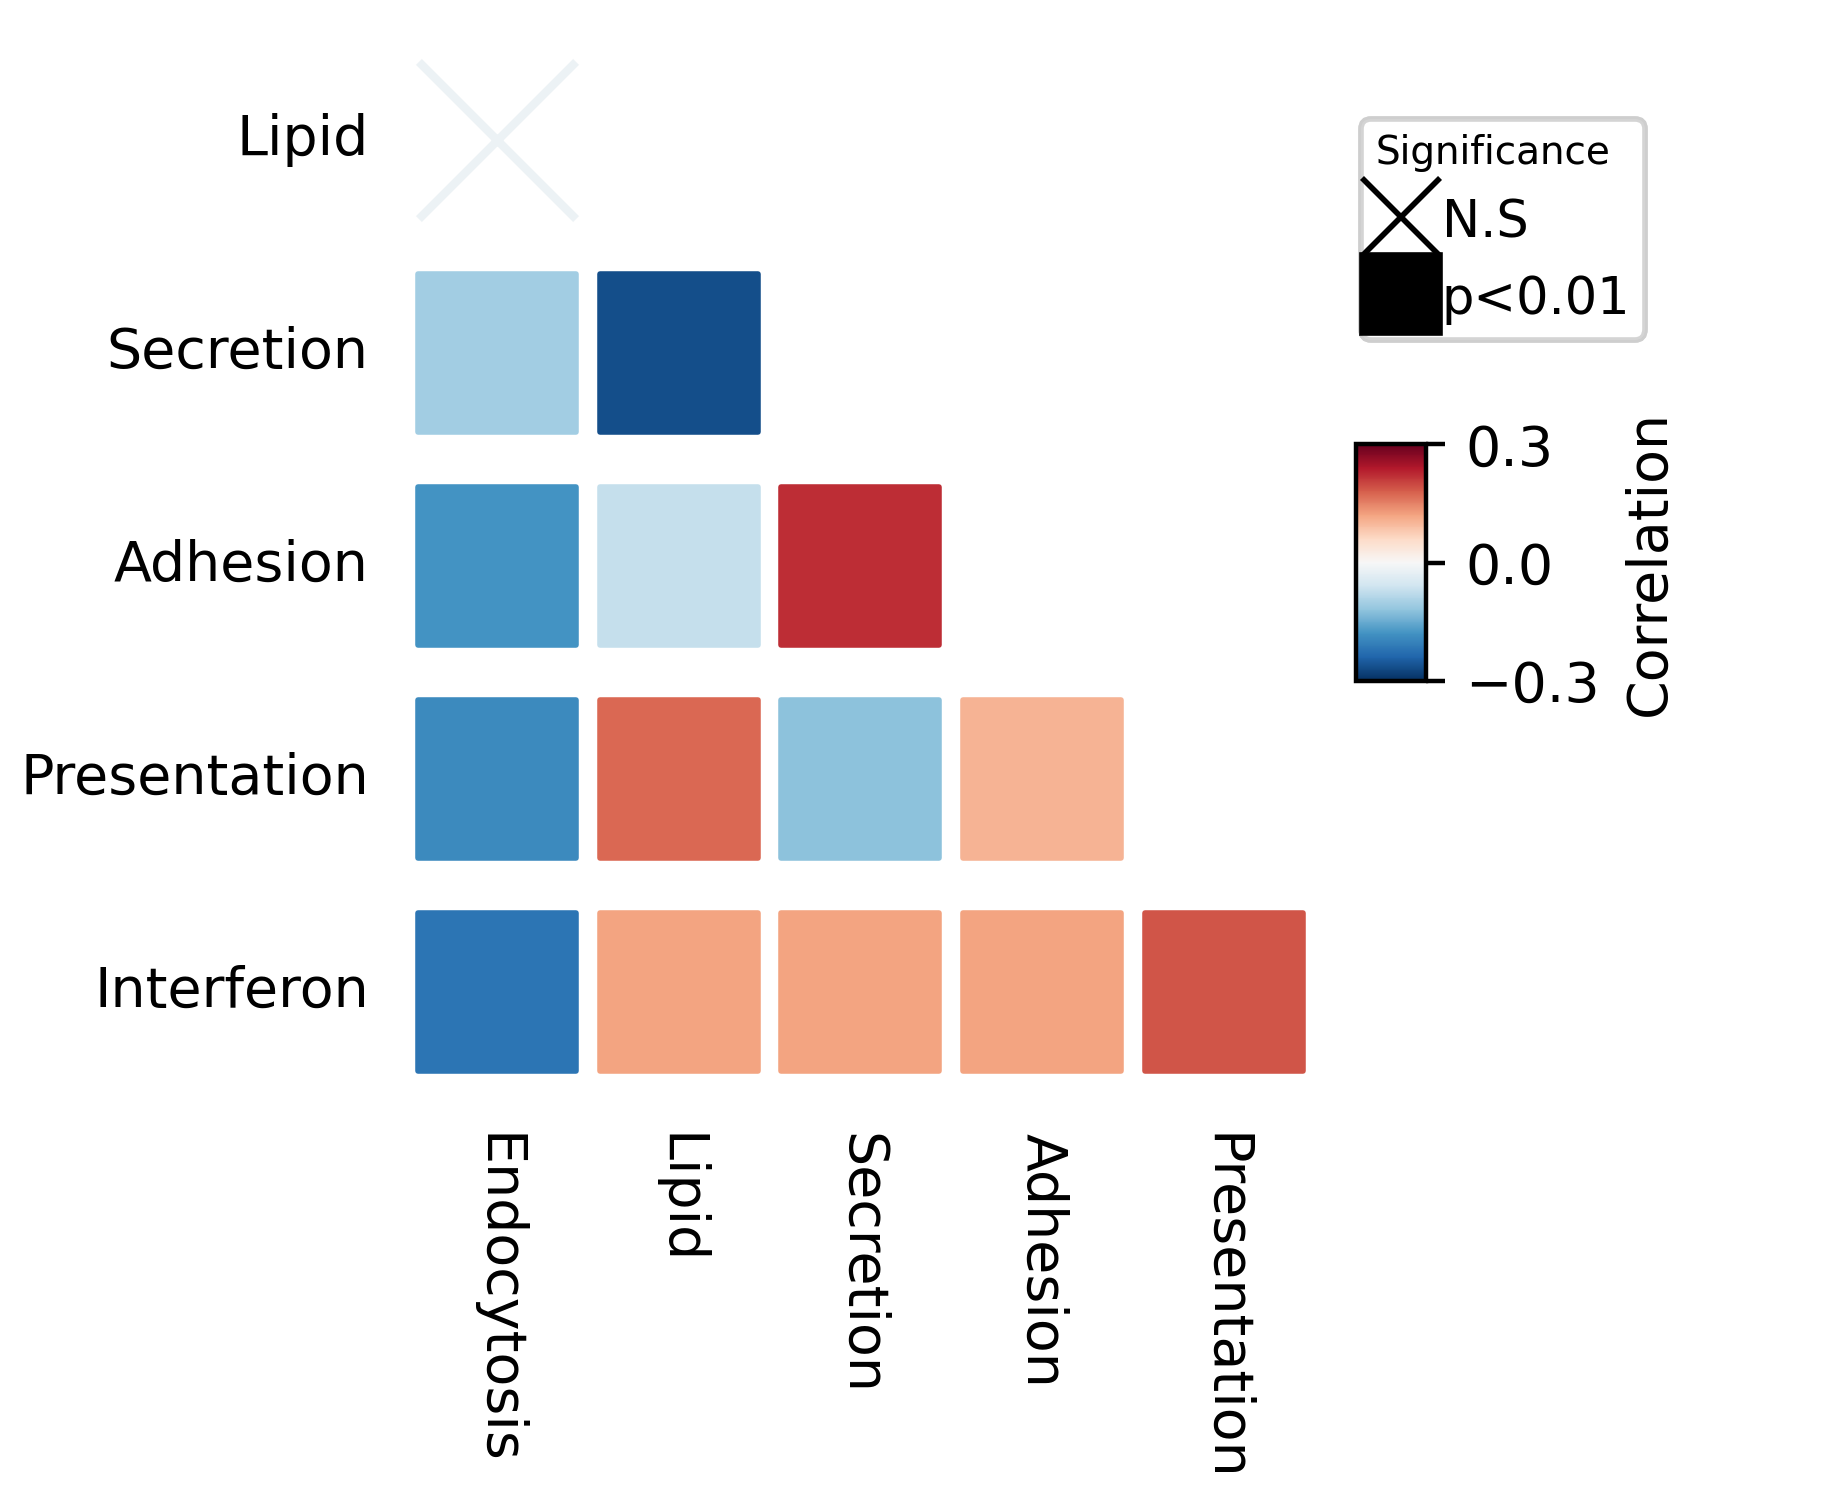

In [40]:
plt.figure(figsize=(3, 3))
plt.rcParams['axes.grid'] = False 
row_ha = HeatmapAnnotation(label=anno_label(pd.Series(order,index=order),colors='k'),axis=0)
col_ha = HeatmapAnnotation(label=anno_label(pd.Series(order,index=order),colors='k'),axis=1)
# col_ha = HeatmapAnnotation(label=anno_label(pd.Series(['Endocytosis','Lipid','Presentation','Interferon','Adhesion','Secretion'])))
cm = DotClustermapPlotter(data=data, x='level_0',y='level_1',value='Correlation',c='Correlation',hue='Significance',
                          s=4,
                          # top_annotation=col_ha,
                          # left_annotation=row_ha,
                          col_split=pd.Series(order[:-1],index=order[:-1]),
                          col_split_order = order[:-1],
                          row_split=pd.Series(order[1:],index=order[1:]),
                          row_split_order = order[1:],
                          marker={'N.S':'x','p<0.01':'s'},
                          vmax=.3,vmin=-.3,cmap='RdBu_r',
                          ratio=200,
                          row_cluster=False,col_cluster=False,
                          show_rownames=True,show_colnames=True,row_names_side='left')
plt.show()

<Axes: >

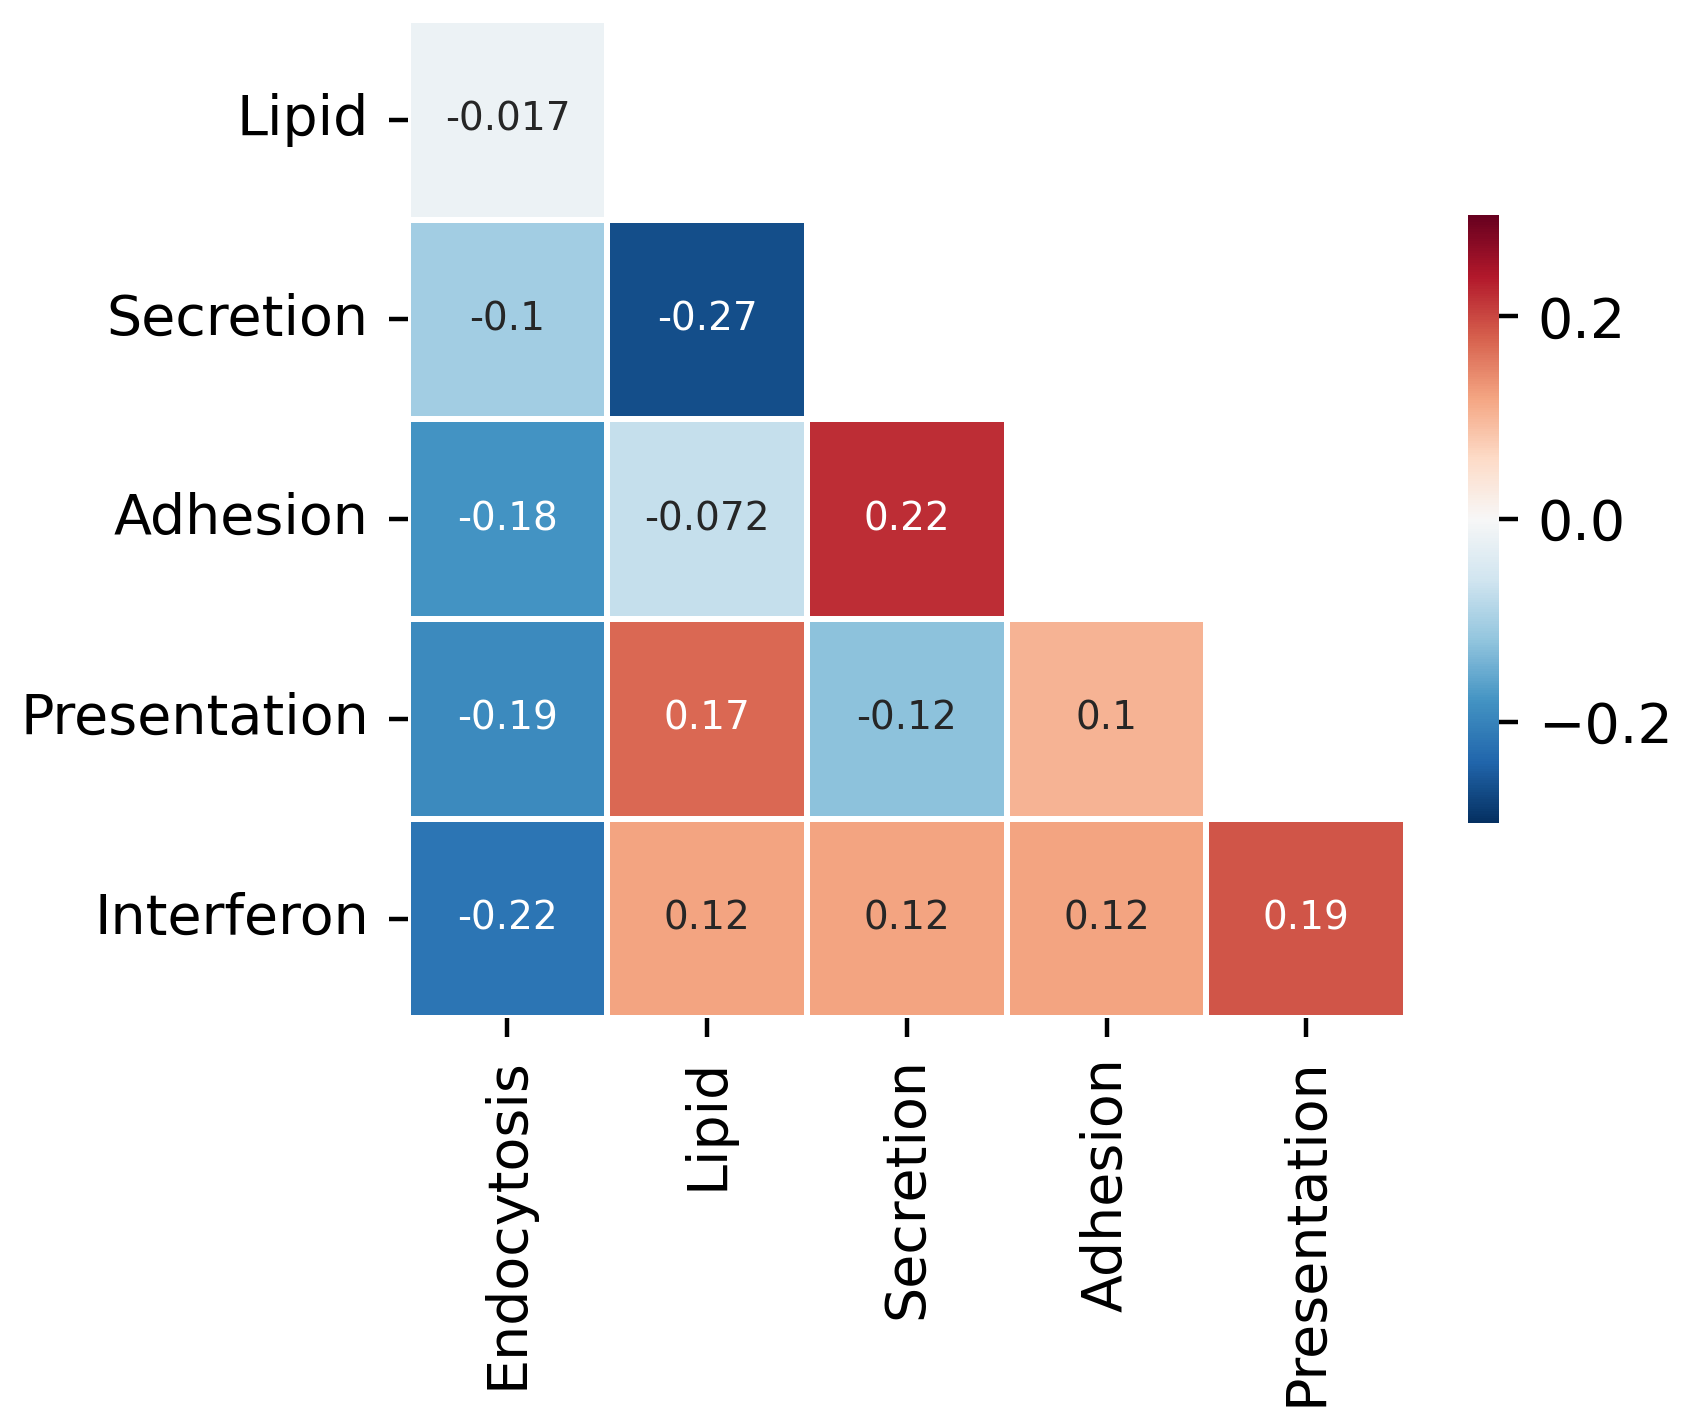

In [41]:
mask = np.triu(corr.iloc[1:,:-1],1)
sns.heatmap(corr.iloc[1:,:-1],
            square=True,cmap='RdBu_r',vmax=.3,vmin=-.3,mask=mask,
            linewidths=1, cbar_kws={"shrink": .5},annot=True)



## Correaltion with external Score M1/M2

### Signature score calculation

In [43]:
ext_sig_gmt_path = f"{EXTERNAL_DATA}/Combined_Jablonski_Alt_Class_Mac.gmt.txt"
# To note, the adata has been normalized before.
ext_scores = sp.ext.VISION(data=adata,gmt_files=[ext_sig_gmt_path],outdir='.')

Rscript /home/analysis/scPipe/scPipe/Rscripts/VISION.R --gmt_files ..//data/external/Combined_Jablonski_Alt_Class_Mac.gmt.txt --h5ad /tmp/tmp2qpubb06/count.h5ad --output_file /tmp/tmp2qpubb06/vision.tsv
$gmt_files
[1] "..//data/external/Combined_Jablonski_Alt_Class_Mac.gmt.txt"

$h5ad
[1] "/tmp/tmp2qpubb06/count.h5ad"

$output_file
[1] "/tmp/tmp2qpubb06/vision.tsv"



/home/analysis/miniconda3/envs/scPipe/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Loading data from ..//data/external/Combined_Jablonski_Alt_Class_Mac.gmt.txt ...

Using 21898/36601 genes detected in 0.10% of cells for signature analysis.
See the `sig_gene_threshold` input to change this behavior.

Evaluating signature scores on cells...

'as(<matrix>, "dgeMatrix")' is deprecated.
Use 'as(as(as(., "dMatrix"), "generalMatrix"), "unpackedMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").
Evaluating signature-gene importance...

Warning messages:
1: In asMethod(object) :
  sparse->dense coercion: allocating vector of size 3.6 GiB
2: In asMethod(object) :
  sparse->dense coercion: allocating vector of size 3.6 GiB


In [44]:
sig_names = ext_scores.columns.tolist()
obs = adata.obs.loc[ext_scores.index,:]
# attach clinical information
ext_scores = ext_scores.merge(obs,left_index=True,right_index=True)[sig_names]
ext_scores

AltActivated_IL4__Jablonski  ClassicallyActivated_LPSIFNy_Jablonski  \
0                         0.620304                                0.554778   
1                         0.618335                                0.725055   
2                         0.643494                                0.562344   
3                         0.507669                                0.574362   
4                         0.628994                                0.604241   
...                            ...                                     ...   
13370                     0.116347                                0.251000   
13371                     0.242584                                0.195595   
13372                     0.244706                                0.441123   
13373                     0.320231                                0.354433   
13374                     0.317801                                0.344585   

       Becker_M_IFNyLPSTNFa  Becker_M_IL4IL13  Guerriero_M1  Guerriero_M2  
0                  0.237796          0.726566      0.114957      1.443931  
1                  0.653528          0.744186      0.467511      0.743332  
2                  0.220626          0.671839      0.251854      2.071983  
3                  0.203773          0.366303      0.162470      0.647655  
4                  0.307045          0.490994      0.142938      1.614397  
...                     ...               ...           ...           ...  
13370              0.389292          0.241345      0.212241      0.254554  
13371              0.173967          0.047709      0.034386      0.706824  
13372              0.393520          0.047482      0.034200      0.579892  
13373             -0.015935          0.324523      0.047004      0.957091  
13374              0.338122          0.237629      0.031114      0.778097  

[13375 rows x 6 columns]

In [45]:
Ext_Score_Map = {
    'AltActivated_IL4__Jablonski':'M2_Jablonski',
    'ClassicallyActivated_LPSIFNy_Jablonski':'M1_Jablonski',
    'Becker_M_IFNyLPSTNFa':'M1_Becker',
    'Becker_M_IL4IL13':'M2_Becker',
    'Guerriero_M1':'M1_Guerriero',
    'Guerriero_M2':'M2_Guerriero',
}
for x in ext_scores:
    adata.obs[Ext_Score_Map[x]]= ext_scores[x]

In [46]:
order = ['Endocytosis','Lipid','Presentation','Adhesion','Secretion','Interferon']+list(Ext_Score_Map.values())
dt =  adata.obs[order]
pvalues = []
for c in dt:
    p = dt.apply(lambda a: scipy.stats.pearsonr(a.values,dt[c].values)[1])
    p.name= c
    pvalues.append(p)
pvalues = pd.concat(pvalues,axis=1)
corr =  dt.corr()

data = corr.unstack().rename('Correlation').to_frame()
data['pvalue'] = pvalues.unstack()
data['Significance'] = 'N.S'
data.loc[data['pvalue']<0.01,'Significance'] = 'p<0.01'

data = data.reset_index()
data = data.loc[(data.level_0.isin(list(Ext_Score_Map.values())))&
                (~data.level_1.isin(list(Ext_Score_Map.values()))),:]

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 28.315333333333335 mm


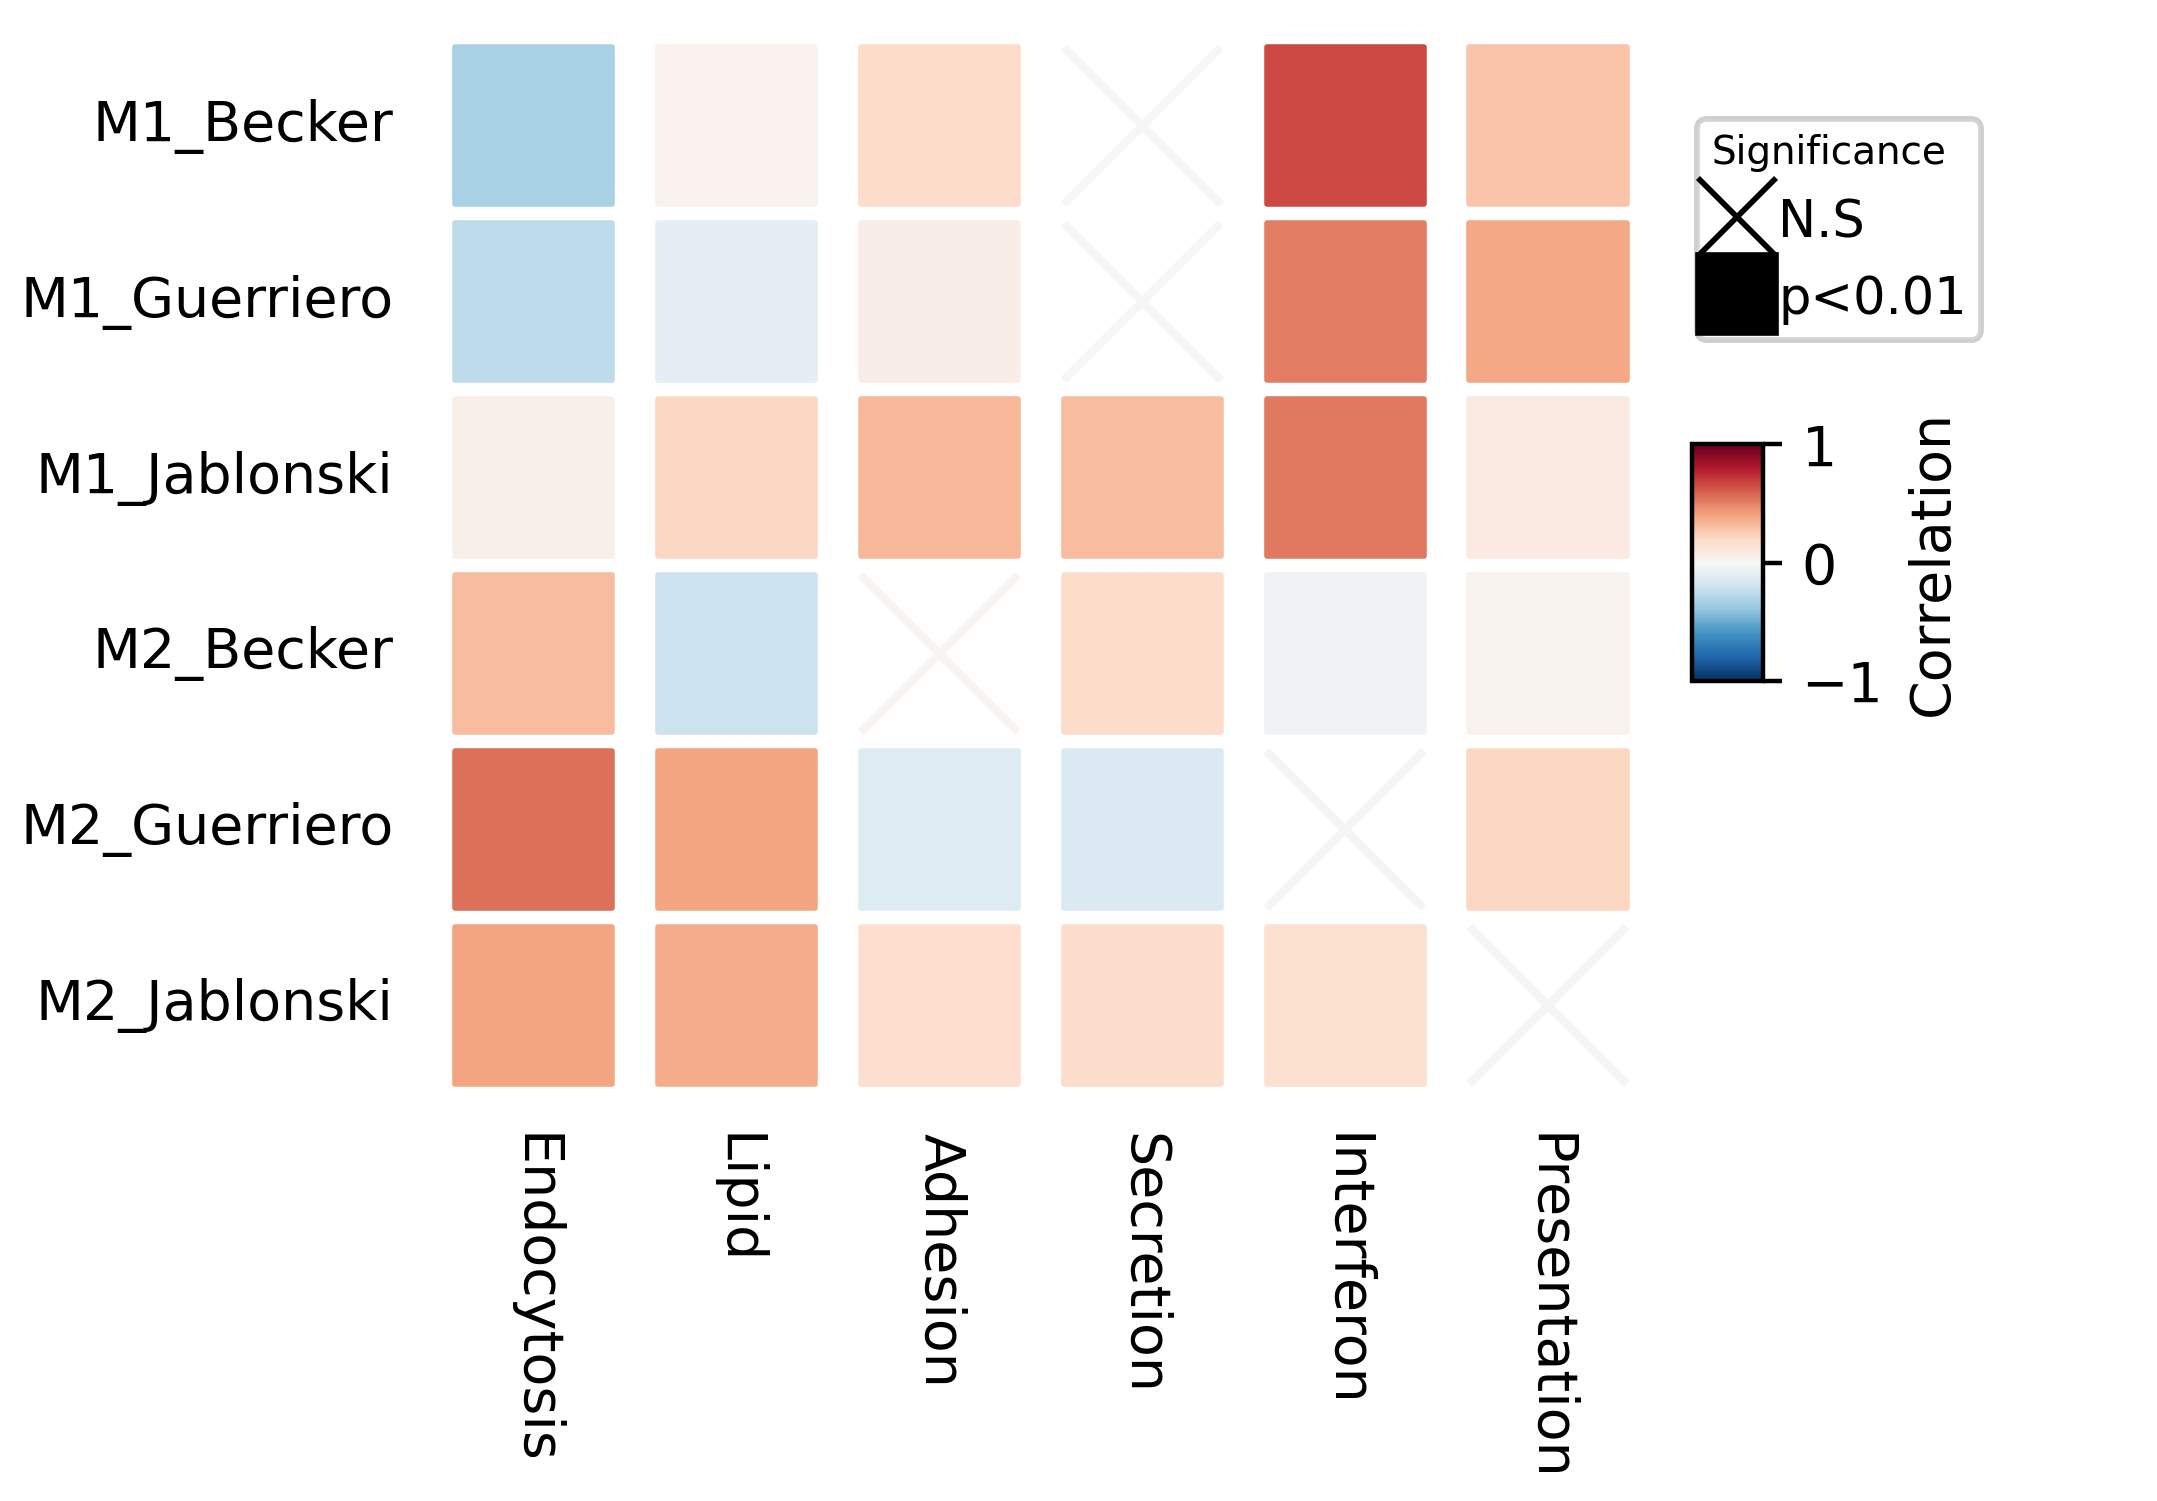

In [47]:
plt.figure(figsize=(4, 3))
plt.rcParams['axes.grid'] = False 
# col_ha = HeatmapAnnotation(label=anno_label(pd.Series(['Endocytosis','Lipid','Presentation','Interferon','Adhesion','Secretion'])))
cm = DotClustermapPlotter(data=data, x='level_1',y='level_0',value='Correlation',c='Correlation',hue='Significance',
                          s=4,
                          # top_annotation=col_ha,
                          # left_annotation=row_ha,
                          # col_split=pd.Series(order[:-1],index=order[:-1]),
                          # col_split_order = order[:-1],
                          # row_split=pd.Series(order[1:],index=order[1:]),
                          # row_split_order = order[1:],
                          marker={'N.S':'x','p<0.01':'s'},
                          vmax=1,vmin=-1,cmap='RdBu_r',
                          ratio=200,
                          row_cluster=False,col_cluster=True,
                          show_rownames=True,show_colnames=True,row_names_side='left')
plt.show()

## Prediction power
### Baseline

In [103]:
x='BestResponse'
timepoints =['Baseline']
explored_z=None
random_var='Patient'
x_order=['favorable response\n(RCB 0-I)','unfavorable response\n(RCB II-III)']
dt = scores.loc[(scores.Timepoint.isin(timepoints)),:].copy()
dt[x] = pd.Categorical(dt[x],x_order,ordered=True)
output_table = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var).replace(MP_anno_map)
output_table.to_csv(f'{RESULT_TABLE}/LmTest/Macs_Baseline_Prediction.csv',index=False)
pvalues = output_table.set_index(['Y'])['Pvalue']
output_table

Ctrl                          Experiment  \
0  favorable response\n(RCB 0-I)  unfavorable response\n(RCB II-III)   
0  favorable response\n(RCB 0-I)  unfavorable response\n(RCB II-III)   
0  favorable response\n(RCB 0-I)  unfavorable response\n(RCB II-III)   
0  favorable response\n(RCB 0-I)  unfavorable response\n(RCB II-III)   
0  favorable response\n(RCB 0-I)  unfavorable response\n(RCB II-III)   
0  favorable response\n(RCB 0-I)  unfavorable response\n(RCB II-III)   

              Y      Coef    log2FC               Pvalue       FDR  
0    Interferon -0.337669 -0.385920  0.11706997547094501  0.351210  
0   Endocytosis -0.260929 -0.238241   0.4869779682814622  0.870828  
0  Presentation -0.151111 -0.103110   0.7256895838264705  0.870828  
0     Secretion  0.012507  0.012833   0.9539976946947053  0.953998  
0      Adhesion  0.208680  0.161566  0.11285184005853974  0.351210  
0         Lipid  0.162073  0.192669   0.6814857020950063  0.870828

### Distribution of MPs between two RCB groups

Text(0.5, 1.02, 'Macrophage cells from baseline samples.')

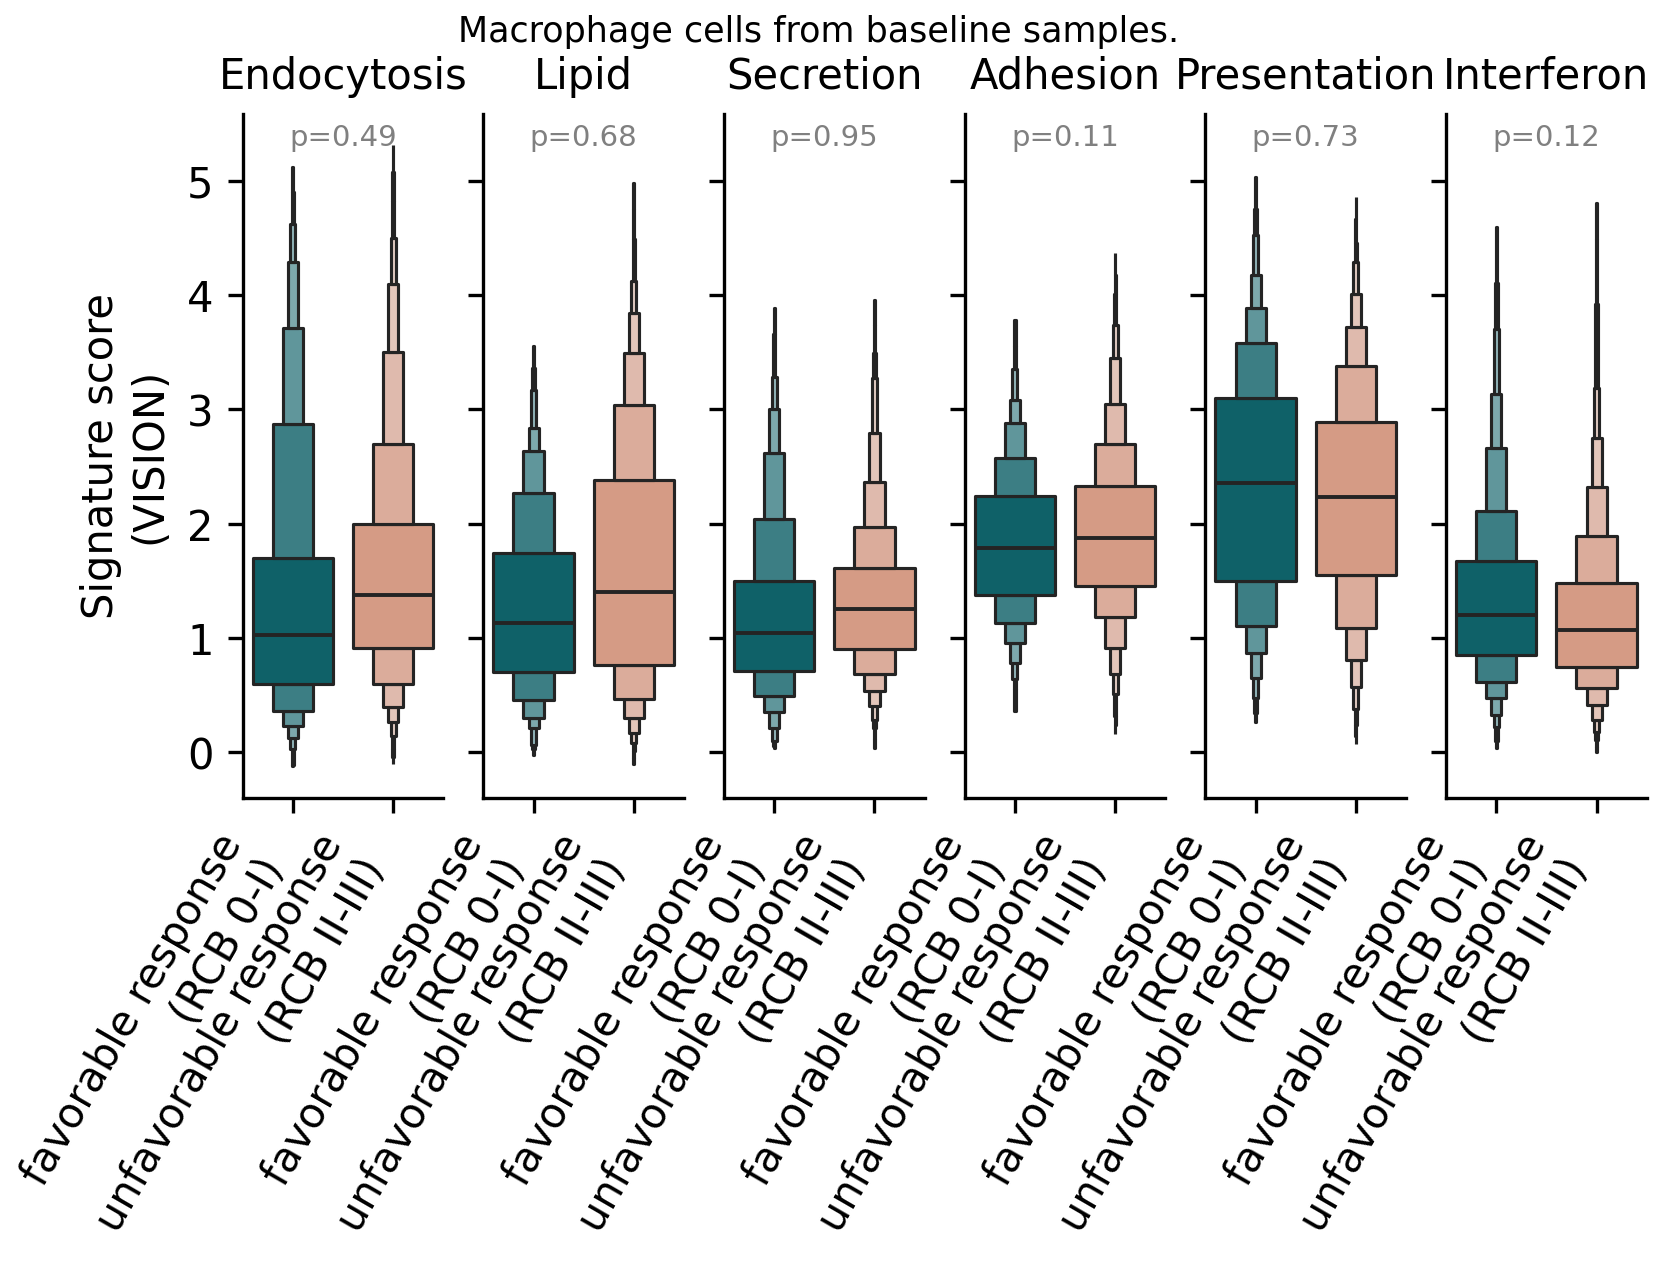

In [104]:
show_mps =  ['Endocytosis','Lipid','Secretion','Adhesion','Presentation','Interferon']
plt_dt = dt.rename(columns=MP_anno_map)
fig,axs=plt.subplots(1,len(show_mps),dpi=150,sharey=True,figsize=(6,3))
for i,subtype in enumerate(show_mps):
    ax=axs[i]
    sns.boxenplot(data=plt_dt,
                  ax=ax,x=x,y=subtype,hue=x,
                  showfliers=False,
                  palette=COLOR_PAlETTE[x])
    # ax.legend_.remove()
    ax.set(xlabel='',title=subtype,ylabel='Signature score\n(VISION)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right',va='top')
    y_loc =5.5
    pvalue = pvalues[subtype]
    if pvalue >= 0.05:
        c='gray'
        label = f"p={pvalue:.2f}"
    else:
        label = f"p={pvalue:.3f}"
        c = 'red'
    ax.text(.5,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
plt.suptitle('Macrophage cells from baseline samples.',y=1.02)

### W3D1

In [105]:
x='BestResponse'
timepoints =['W3D1']
explored_z=None
random_var='Patient'
x_order=['favorable response\n(RCB 0-I)','unfavorable response\n(RCB II-III)']
dt = scores.loc[(scores.Timepoint.isin(timepoints)),:].copy()
dt[x] = pd.Categorical(dt[x],x_order,ordered=True)
output_table = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var).replace(MP_anno_map)
output_table.to_csv(f'{RESULT_TABLE}/LmTest/Macs_W3D1_Prediction.csv',index=False)
pvalues = output_table.set_index(['Y'])['Pvalue']
output_table

Ctrl                          Experiment  \
0  favorable response\n(RCB 0-I)  unfavorable response\n(RCB II-III)   
0  favorable response\n(RCB 0-I)  unfavorable response\n(RCB II-III)   
0  favorable response\n(RCB 0-I)  unfavorable response\n(RCB II-III)   
0  favorable response\n(RCB 0-I)  unfavorable response\n(RCB II-III)   
0  favorable response\n(RCB 0-I)  unfavorable response\n(RCB II-III)   
0  favorable response\n(RCB 0-I)  unfavorable response\n(RCB II-III)   

              Y      Coef    log2FC                  Pvalue           FDR  
0    Interferon -0.694551 -0.746749  2.4025647622069175e-10  1.441539e-09  
0  Presentation -0.758005 -0.418593     0.09666201380744124  1.899981e-01  
0         Lipid -0.334660 -0.357544     0.44641346910698665  4.464135e-01  
0     Secretion  0.342846  0.376491     0.12666543315769316  1.899981e-01  
0      Adhesion  0.733965  0.524527     0.12028417416318306  1.899981e-01  
0   Endocytosis  0.536440  0.547531     0.31061974097344075  3.727437e-01

### Distribution of MPs between two RCB groups

Text(0.5, 1.02, 'Macrophage cells from baseline samples.')

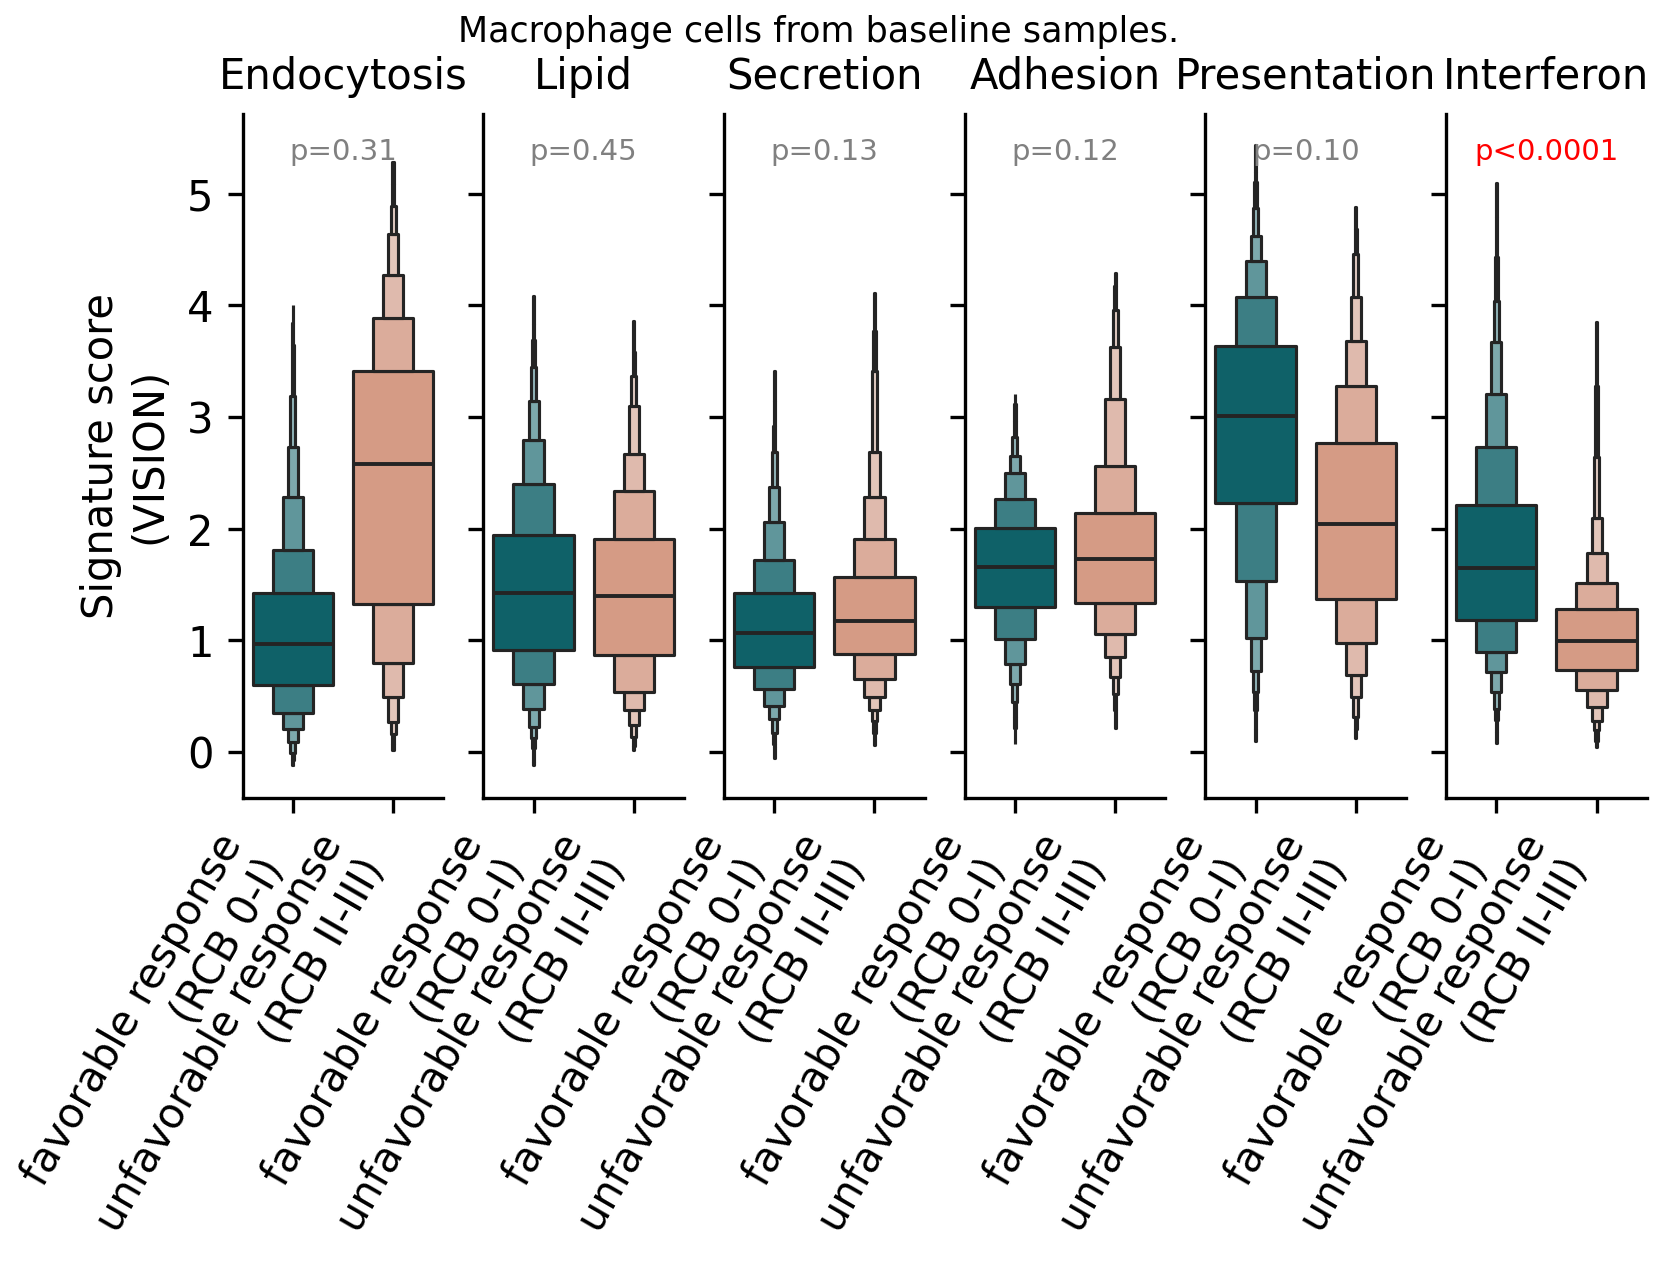

In [106]:
show_mps =  ['Endocytosis','Lipid','Secretion','Adhesion','Presentation','Interferon']
plt_dt = dt.rename(columns=MP_anno_map)
fig,axs=plt.subplots(1,len(show_mps),dpi=150,sharey=True,figsize=(6,3))
for i,subtype in enumerate(show_mps):
    ax=axs[i]
    sns.boxenplot(data=plt_dt,
                  ax=ax,x=x,y=subtype,hue=x,
                  showfliers=False,
                  palette=COLOR_PAlETTE[x])
    # ax.legend_.remove()
    ax.set(xlabel='',title=subtype,ylabel='Signature score\n(VISION)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right',va='top')
    y_loc =5.5
    pvalue = pvalues[subtype]
    if pvalue >= 0.05:
        c='gray'
        label = f"p={pvalue:.2f}"
    elif pvalue >= 0.0001:
        label = f"p={pvalue:.3f}"
        c = 'red'
    else:
        label = f"p<0.0001"
        c = 'red'

    ax.text(.5,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
plt.suptitle('Macrophage cells from baseline samples.',y=1.02)

# Treatment-induced program shifts

## Monotherapy
### Chemotherapy induced MPs shift

In [116]:
tx_arm = 'Chemo->Combo'
x='Timepoint'
explored_z='BestResponse'
random_var='Patient'
dt = scores.loc[(scores.Timepoint.isin(['Baseline','W3D1']))&
                (scores.Treatment_Arm==tx_arm),:].copy()
## subsets pts with samples biopsied at both timepoint
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
## perform linear mixture model test
dt[x] = pd.Categorical(dt[x],['Baseline','W3D1'],ordered=True)
print(dt.groupby(explored_z)[random_var].nunique())
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
result.Y =  result.Y.map(MP_anno_map)
result

BestResponse
favorable response\n(RCB 0-I)         1
unfavorable response\n(RCB II-III)    1
Name: Patient, dtype: int64


Ctrl Experiment             Y      Coef    log2FC  \
0  Baseline       W3D1         Lipid  0.060296 -0.019388   
0  Baseline       W3D1  Presentation  0.459968  0.020793   
0  Baseline       W3D1   Endocytosis  0.290152  0.037752   
0  Baseline       W3D1      Adhesion  0.860129  0.039188   
0  Baseline       W3D1      Adhesion -0.047032  0.039188   
0  Baseline       W3D1         Lipid  0.087398  0.085525   
0  Baseline       W3D1         Lipid -0.118304  0.085525   
0  Baseline       W3D1    Interferon  0.387228  0.135725   
0  Baseline       W3D1  Presentation -0.547725  0.261146   
0  Baseline       W3D1  Presentation  0.612887  0.261146   
0  Baseline       W3D1      Adhesion  0.072492  0.272538   
0  Baseline       W3D1   Endocytosis -0.305063  0.322623   
0  Baseline       W3D1   Endocytosis  0.380476  0.322623   
0  Baseline       W3D1     Secretion  0.354195  0.366688   
0  Baseline       W3D1    Interferon  0.483368  0.417662   
0  Baseline       W3D1    Interferon -0.246314  0.417662   
0  Baseline       W3D1     Secretion  0.353587  0.418141   
0  Baseline       W3D1     Secretion  0.358198  0.418141   

                   Pvalue                                       BestResponse  \
0     0.11724869657883565  favorable response\n(RCB 0-I)+unfavorable resp...   
0  1.9643573156649816e-25  favorable response\n(RCB 0-I)+unfavorable resp...   
0   2.813454576218286e-13  favorable response\n(RCB 0-I)+unfavorable resp...   
0    9.74056909531763e-11                 unfavorable response\n(RCB II-III)   
0     0.12488827566344311                      favorable response\n(RCB 0-I)   
0    0.044197009045760516                      favorable response\n(RCB 0-I)   
0     0.05179364734990565                 unfavorable response\n(RCB II-III)   
0   1.323963782479462e-27  favorable response\n(RCB 0-I)+unfavorable resp...   
0   2.782917548831889e-09                 unfavorable response\n(RCB II-III)   
0    8.05706849858789e-38                      favorable response\n(RCB 0-I)   
0    0.027381121501240207  favorable response\n(RCB 0-I)+unfavorable resp...   
0    0.047355119478454354                 unfavorable response\n(RCB II-III)   
0   7.094492466416647e-23                      favorable response\n(RCB 0-I)   
0   6.767887671115667e-38  favorable response\n(RCB 0-I)+unfavorable resp...   
0  1.8680303404357103e-35                      favorable response\n(RCB 0-I)   
0   0.0007172358725175933                 unfavorable response\n(RCB II-III)   
0   1.252376693812437e-34                      favorable response\n(RCB 0-I)   
0   3.684521129628905e-05                 unfavorable response\n(RCB II-III)   

        FDR  
0  0.117249  
0       0.0  
0       0.0  
0       0.0  
0  0.124888  
0  0.053036  
0  0.051794  
0       0.0  
0       0.0  
0       0.0  
0  0.032857  
0  0.051794  
0       0.0  
0       0.0  
0       0.0  
0  0.001076  
0       0.0  
0  0.000074

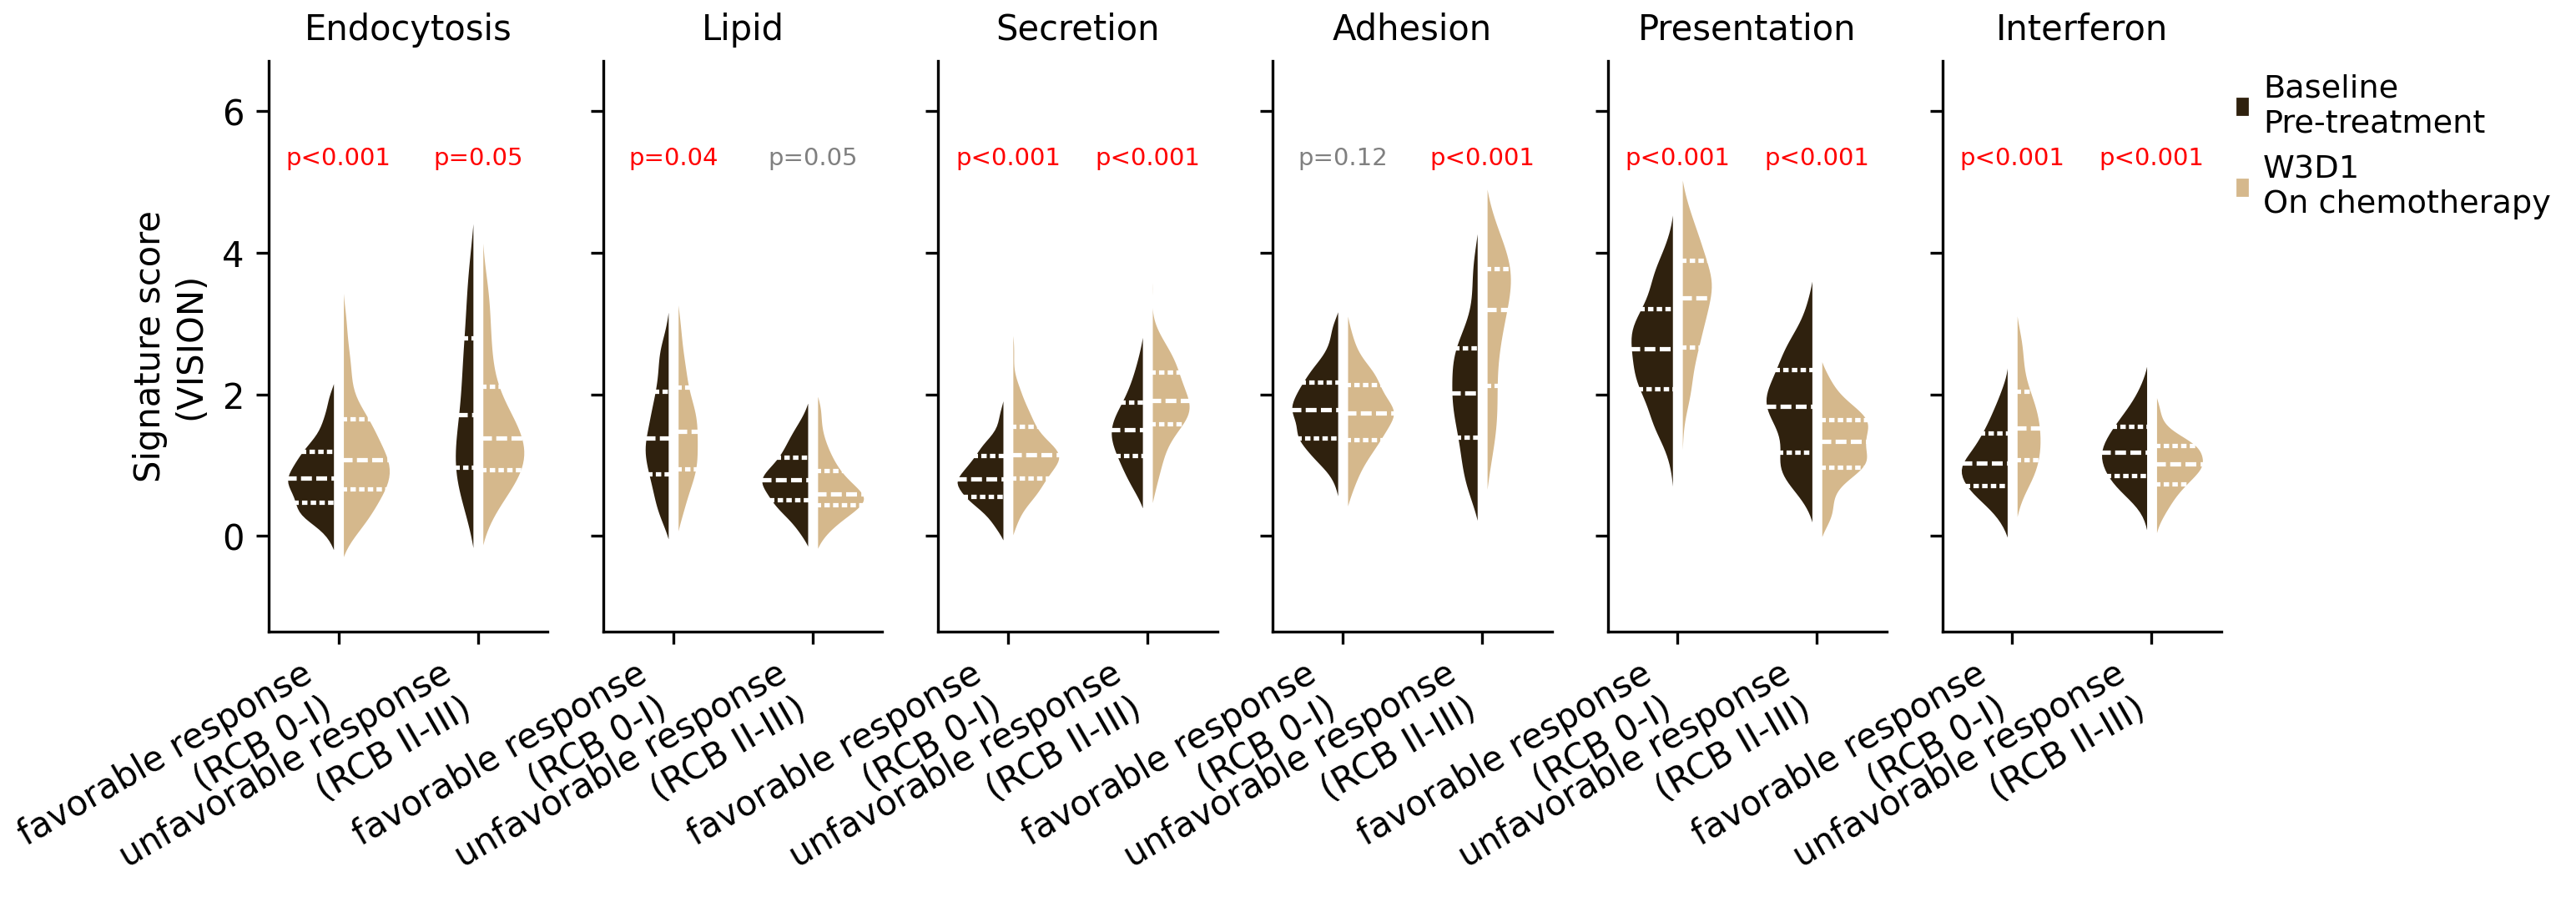

In [117]:
pvalues = result.set_index(['Y',explored_z])['Pvalue']
plt_dt = dt.rename(columns=MP_anno_map)
fig,axs=plt.subplots(1,6,dpi=150,sharey=True,figsize=(10,3))
for i,subtype in enumerate(show_mps):
    ax=axs[i]
    sns.violinplot(data=plt_dt,
                  x='BestResponse',y=subtype,hue='Timepoint',
                  ax=ax,
                  split=True, gap=.1, inner="quart",linecolor='white',
                  palette=COLOR_PAlETTE['Timepoint'])

    ## Add pvalue
    y_loc =5.5
    for xtick in ax.get_xticklabels():
        x_loc,_ = xtick.get_position()
        text = xtick.get_text()
        if pvalues[subtype,text] >= 0.05:
            c='gray'
            label = f"p={pvalues[subtype,text]:.2f}"
        elif pvalues[subtype,text] >= 0.01:
            label = f"p={pvalues[subtype,text]:.2f}"
            c = 'red'
        elif pvalues[subtype,text] >= 0.001:
            label = f"p={pvalues[subtype,text]:.3f}"
            c = 'red'
        else:
            label = "p<0.001"
            c = 'red'
        ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
    ### rename legend label
    if i !=5:
        ax.legend_.remove()
    else:
        handles, previous_labels = ax.get_legend_handles_labels()
        new_labels = [ {'Baseline':'Baseline\nPre-treatment',
                        'W3D1':'W3D1\nOn chemotherapy'}[text]for text in previous_labels]
        ax.legend(loc=(1,.7),handles=handles, labels=new_labels)
    ax.set(xlabel='',title=subtype,ylabel='Signature score\n(VISION)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

### Pembro induced MPs shifts

In [109]:
tx_arm = 'ICI->Combo'
x='Timepoint'
explored_z='BestResponse'
random_var='Patient'
dt = scores.loc[(scores.Timepoint.isin(['Baseline','W3D1']))&
                (scores.Treatment_Arm==tx_arm),:].copy()
## subsets pts with samples biopsied at both timepoint
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
## perform linear mixture model test
dt[x] = pd.Categorical(dt[x],['Baseline','W3D1'],ordered=True)
print(dt.groupby(explored_z)[random_var].nunique())
dt[explored_z] = dt[explored_z].astype(str)
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var).drop_duplicates(['Y',explored_z])
result.Y =  result.Y.map(MP_anno_map)
result

BestResponse
favorable response\n(RCB 0-I)         0
unfavorable response\n(RCB II-III)    3
Name: Patient, dtype: int64


Ctrl Experiment             Y      Coef    log2FC  \
0  Baseline       W3D1   Endocytosis -0.259663 -0.420072   
0  Baseline       W3D1         Lipid -0.053036 -0.169441   
0  Baseline       W3D1      Adhesion  0.120779  0.047046   
0  Baseline       W3D1  Presentation  0.203133  0.193835   
0  Baseline       W3D1     Secretion  0.237331  0.204705   
0  Baseline       W3D1    Interferon  0.285555  0.388245   

                   Pvalue                        BestResponse       FDR  
0  1.8276531412923458e-07  unfavorable response\n(RCB II-III)       0.0  
0      0.2443503154130711  unfavorable response\n(RCB II-III)   0.24435  
0     0.04534989027846949  unfavorable response\n(RCB II-III)   0.05442  
0     0.00642053605101334  unfavorable response\n(RCB II-III)  0.009631  
0   5.067970631405081e-08  unfavorable response\n(RCB II-III)       0.0  
0  1.7995854943885548e-10  unfavorable response\n(RCB II-III)       0.0

In [118]:
MP_anno_map

{'MP1': 'Endocytosis',
 'MP4': 'Lipid',
 'MP7': 'Interferon',
 'MP6': 'Adhesion',
 'MP5': 'Secretion',
 'MP8': 'Presentation'}

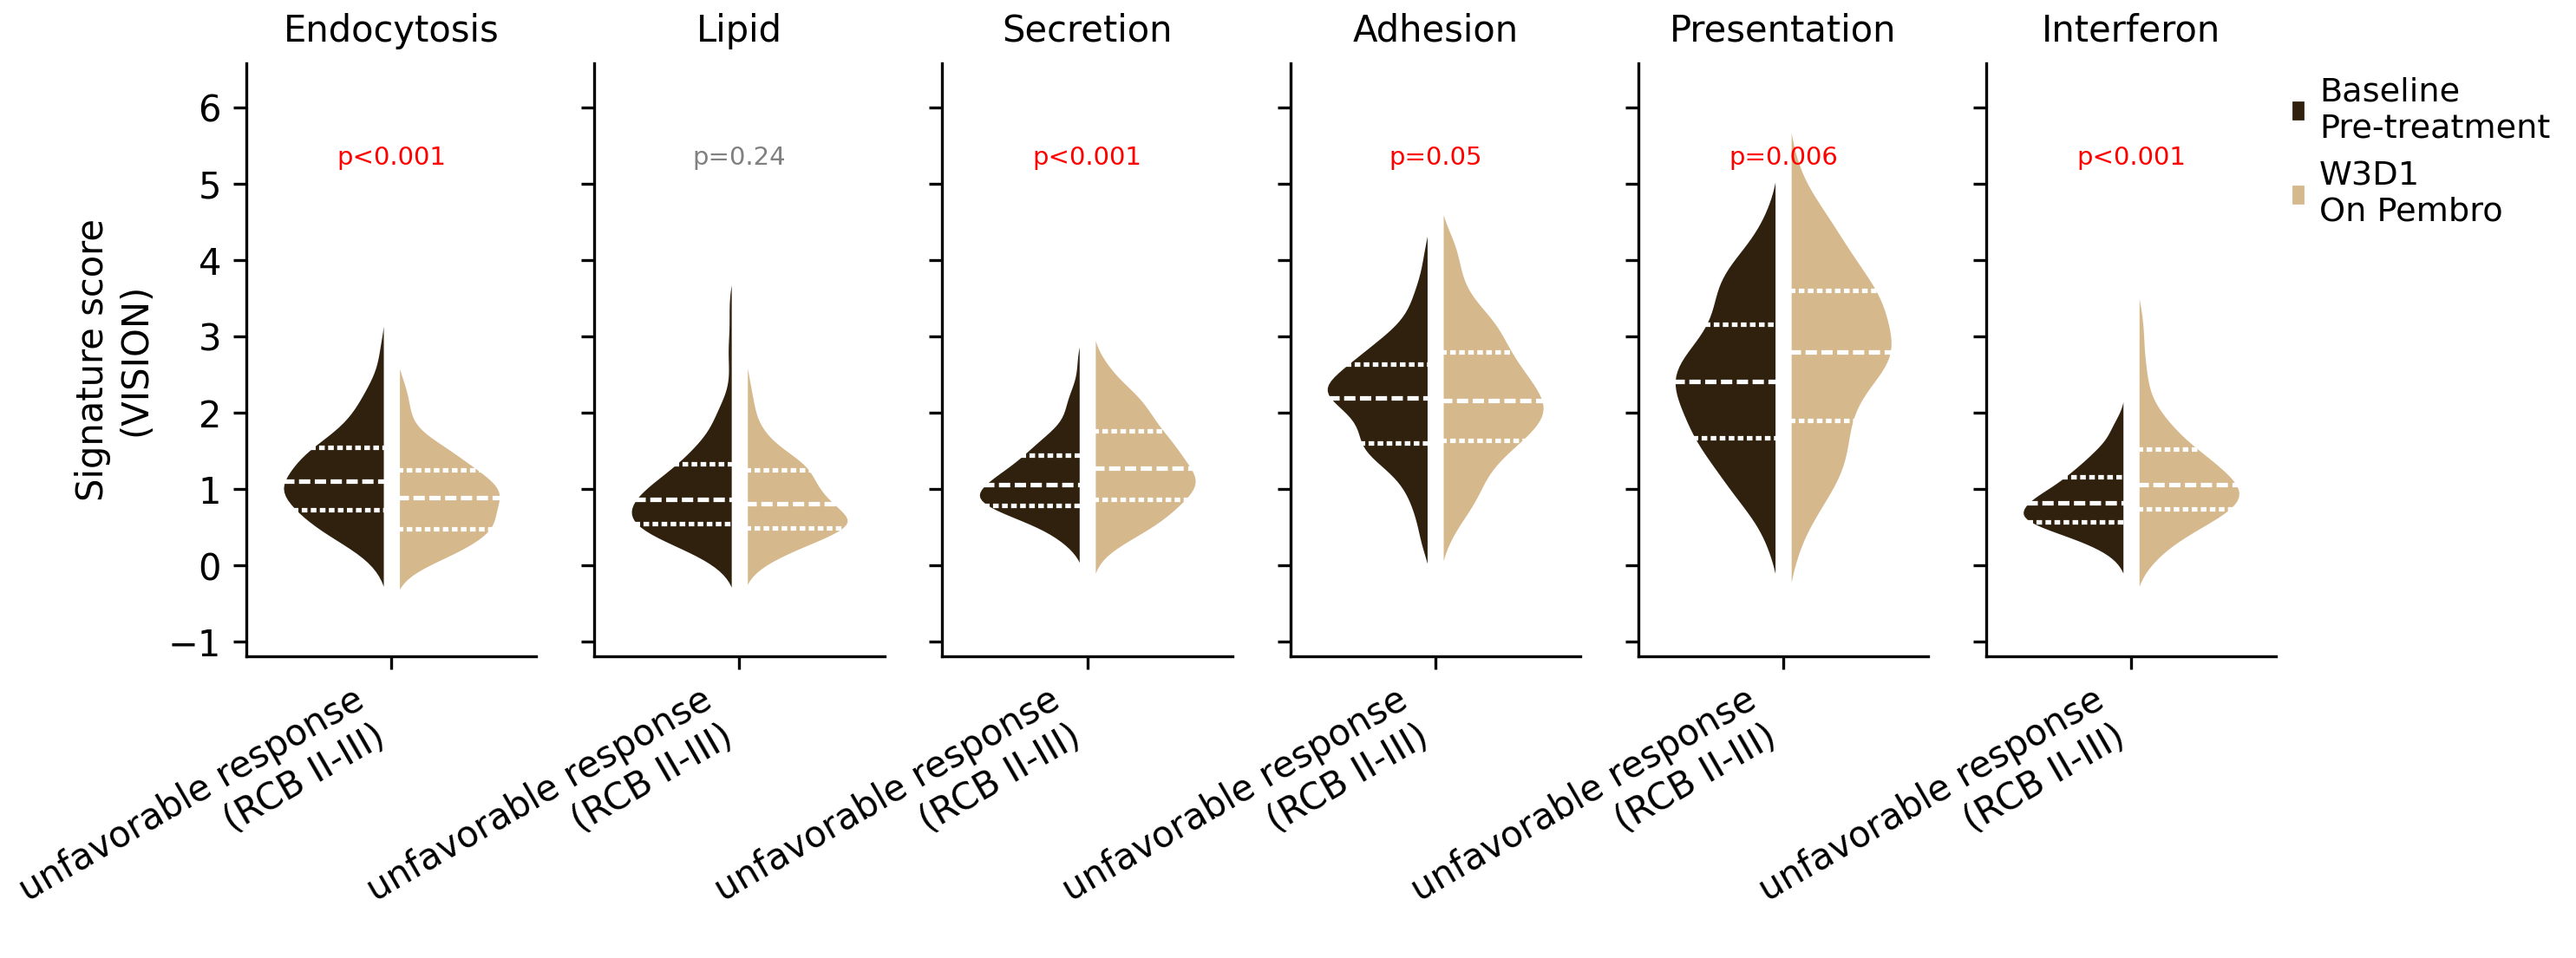

In [110]:
pvalues = result.set_index(['Y',explored_z])['Pvalue']
plt_dt = dt.rename(columns=MP_anno_map)
fig,axs=plt.subplots(1,6,dpi=150,sharey=True,figsize=(10,3))
for i,subtype in enumerate(show_mps):
    ax=axs[i]
    sns.violinplot(data=plt_dt,
                  x='BestResponse',y=subtype,hue='Timepoint',
                  ax=ax,
                  split=True, gap=.1, inner="quart",linecolor='white',
                  palette=COLOR_PAlETTE['Timepoint'])

    ## Add pvalue
    y_loc =5.5
    for xtick in ax.get_xticklabels():
        x_loc,_ = xtick.get_position()
        text = xtick.get_text()
        if pvalues[subtype,text] >= 0.05:
            c='gray'
            label = f"p={pvalues[subtype,text]:.2f}"
        elif pvalues[subtype,text] >= 0.01:
            label = f"p={pvalues[subtype,text]:.2f}"
            c = 'red'
        elif pvalues[subtype,text] >= 0.001:
            label = f"p={pvalues[subtype,text]:.3f}"
            c = 'red'
        else:
            label = "p<0.001"
            c = 'red'
        ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
    ### rename legend label
    if i !=5:
        ax.legend_.remove()
    else:
        handles, previous_labels = ax.get_legend_handles_labels()
        new_labels = [ {'Baseline':'Baseline\nPre-treatment',
                        'W3D1':'W3D1\nOn Pembro'}[text]for text in previous_labels]
        ax.legend(loc=(1,.7),handles=handles, labels=new_labels)
    ax.set(xlabel='',title=subtype,ylabel='Signature score\n(VISION)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

## Combination induced MPs shifts

In [119]:
x='Timepoint'
explored_z='BestResponse'
random_var='Patient'
dt = scores.loc[(scores.Timepoint.isin(['W3D1','W7D1'])),:].copy()
## subsets pts with samples biopsied at both timepoint
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
## perform linear mixture model test
dt[x] = pd.Categorical(dt[x],['W3D1','W7D1'],ordered=True)
print(dt.groupby(explored_z)[random_var].nunique())
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
result.Y =  result.Y.map(MP_anno_map)
result

BestResponse
favorable response\n(RCB 0-I)         2
unfavorable response\n(RCB II-III)    3
Name: Patient, dtype: int64


Ctrl Experiment             Y      Coef    log2FC                  Pvalue  \
0  W3D1       W7D1      Adhesion  -0.36724 -0.401676   6.759068184633492e-70   
0  W3D1       W7D1    Interferon -0.192707   -0.3354   2.708884509224916e-12   
0  W3D1       W7D1      Adhesion -0.624889 -0.273008  3.5463652756123165e-38   
0  W3D1       W7D1      Adhesion -0.271218 -0.273008   2.221352676306014e-32   
0  W3D1       W7D1     Secretion -0.289005 -0.179905   3.153471099946609e-13   
0  W3D1       W7D1     Secretion -0.075918 -0.179905   0.0008263803620552346   
0  W3D1       W7D1    Interferon -0.212432 -0.178867   5.845918791603261e-06   
0  W3D1       W7D1    Interferon -0.186187 -0.178867   2.591420510123088e-08   
0  W3D1       W7D1     Secretion -0.133367  -0.17539  1.2779952940662456e-11   
0  W3D1       W7D1  Presentation -0.079835 -0.013349    0.022535851147527916   
0  W3D1       W7D1  Presentation  -0.15353  0.060324    0.016107222090780613   
0  W3D1       W7D1  Presentation -0.050552  0.060324     0.22304841279346382   
0  W3D1       W7D1         Lipid  0.521047  0.218856  1.2967541542114828e-67   
0  W3D1       W7D1   Endocytosis  0.237344  0.256432   2.251584156401762e-05   
0  W3D1       W7D1   Endocytosis  0.158216  0.256432  2.3347349496702187e-07   
0  W3D1       W7D1   Endocytosis  0.179733  0.279671   1.737725859531543e-11   
0  W3D1       W7D1         Lipid  0.109881  0.656252    0.023228914877820025   
0  W3D1       W7D1         Lipid  0.674985  0.656252   1.064241198115136e-78   

                                        BestResponse       FDR  
0  favorable response\n(RCB 0-I)+unfavorable resp...       0.0  
0  favorable response\n(RCB 0-I)+unfavorable resp...       0.0  
0                 unfavorable response\n(RCB II-III)       0.0  
0                      favorable response\n(RCB 0-I)       0.0  
0                 unfavorable response\n(RCB II-III)       0.0  
0                      favorable response\n(RCB 0-I)  0.000992  
0                 unfavorable response\n(RCB II-III)  0.000012  
0                      favorable response\n(RCB 0-I)       0.0  
0  favorable response\n(RCB 0-I)+unfavorable resp...       0.0  
0  favorable response\n(RCB 0-I)+unfavorable resp...  0.022536  
0                 unfavorable response\n(RCB II-III)  0.019329  
0                      favorable response\n(RCB 0-I)  0.223048  
0  favorable response\n(RCB 0-I)+unfavorable resp...       0.0  
0                 unfavorable response\n(RCB II-III)  0.000034  
0                      favorable response\n(RCB 0-I)       0.0  
0  favorable response\n(RCB 0-I)+unfavorable resp...       0.0  
0                 unfavorable response\n(RCB II-III)  0.023229  
0                      favorable response\n(RCB 0-I)       0.0

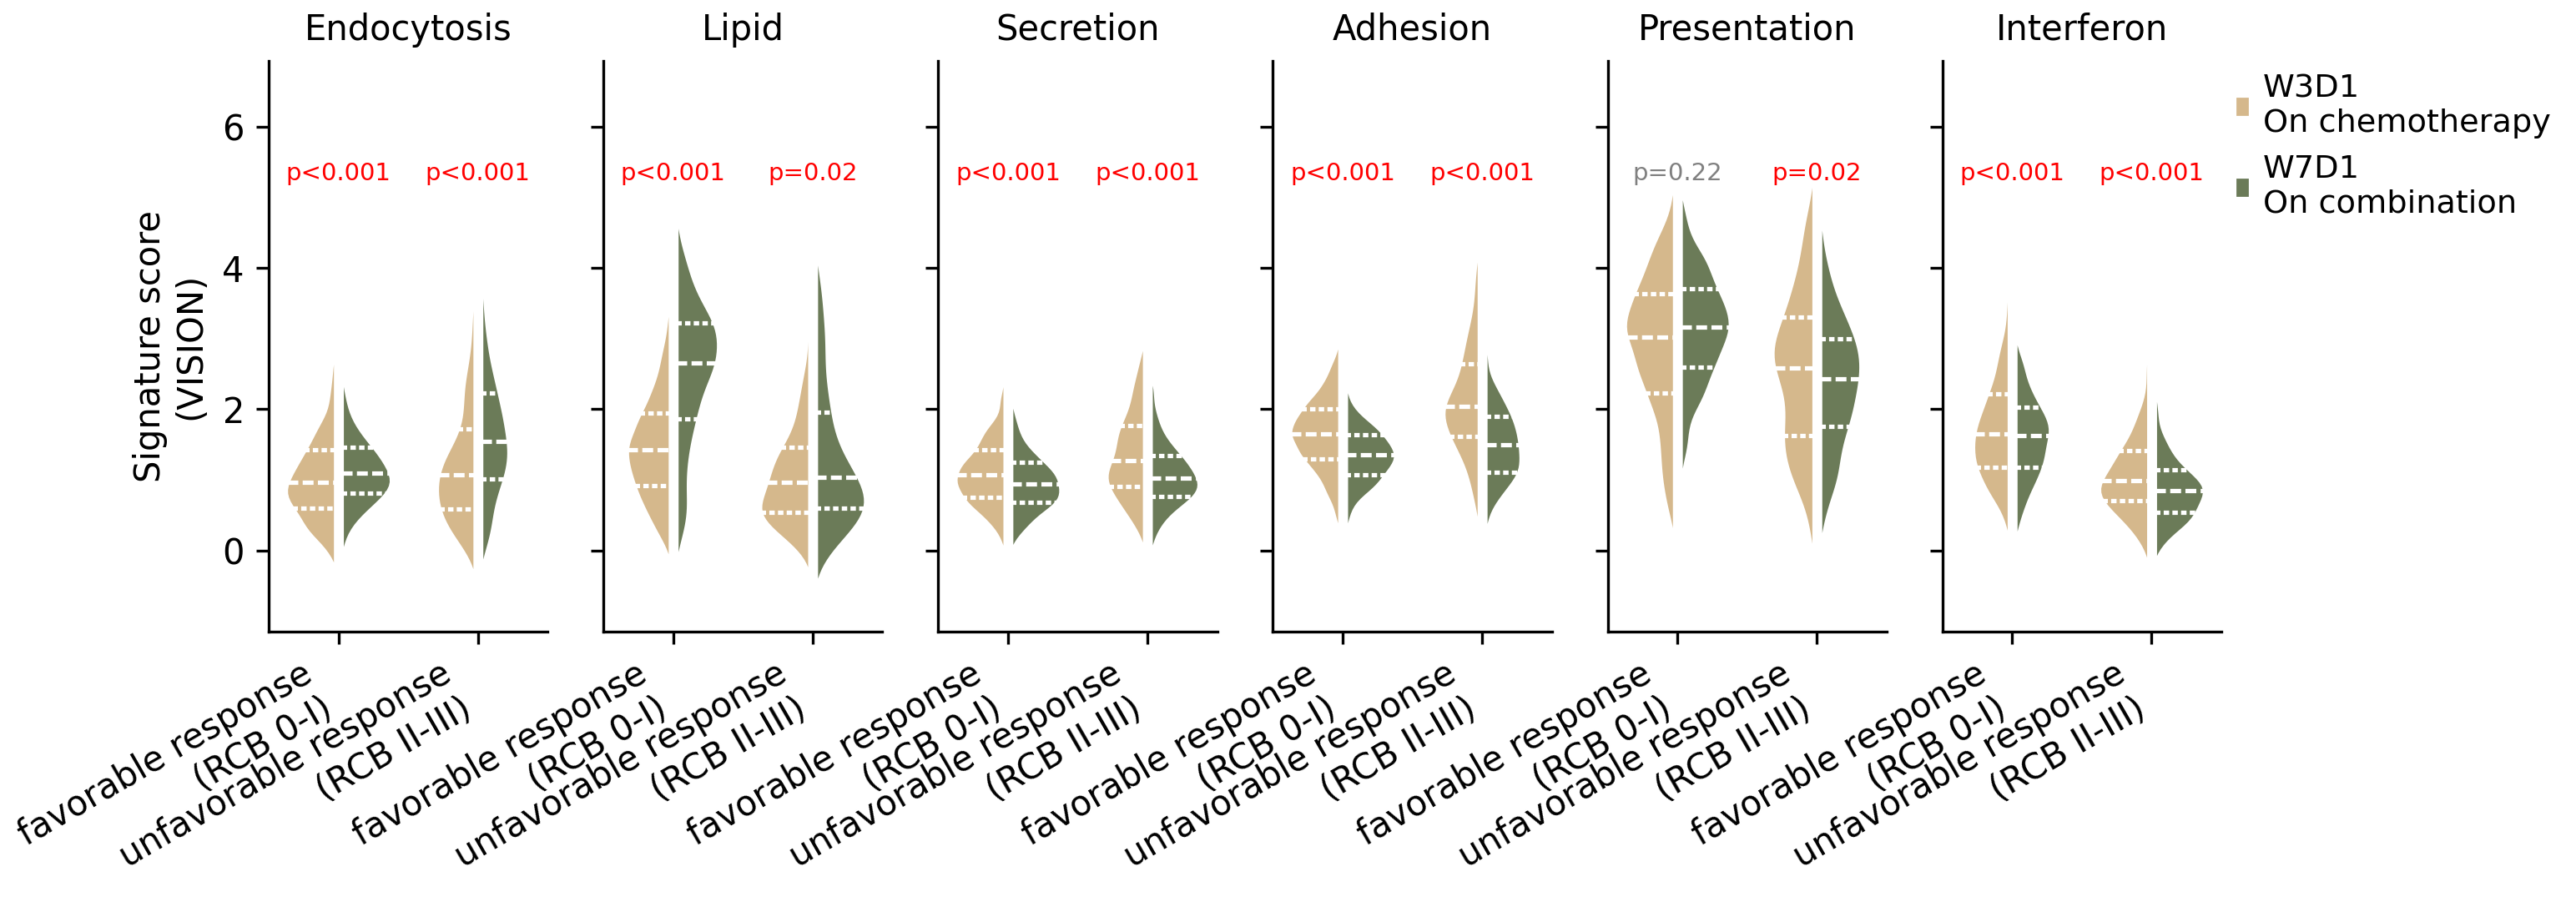

In [120]:
pvalues = result.set_index(['Y',explored_z])['Pvalue']
plt_dt = dt.rename(columns=MP_anno_map)
fig,axs=plt.subplots(1,6,dpi=150,sharey=True,figsize=(10,3))
for i,subtype in enumerate(show_mps):
    ax=axs[i]
    sns.violinplot(data=plt_dt,
                  x='BestResponse',y=subtype,hue='Timepoint',
                  ax=ax,
                  split=True, gap=.1, inner="quart",linecolor='white',
                  palette=COLOR_PAlETTE['Timepoint'])

    ## Add pvalue
    y_loc =5.5
    for xtick in ax.get_xticklabels():
        x_loc,_ = xtick.get_position()
        text = xtick.get_text()
        if pvalues[subtype,text] >= 0.05:
            c='gray'
            label = f"p={pvalues[subtype,text]:.2f}"
        elif pvalues[subtype,text] >= 0.01:
            label = f"p={pvalues[subtype,text]:.2f}"
            c = 'red'
        elif pvalues[subtype,text] >= 0.001:
            label = f"p={pvalues[subtype,text]:.3f}"
            c = 'red'
        else:
            label = "p<0.001"
            c = 'red'
        ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
    ### rename legend label
    if i !=5:
        ax.legend_.remove()
    else:
        handles, previous_labels = ax.get_legend_handles_labels()
        new_labels = [ {'W7D1':'W7D1\nOn combination',
                        'W3D1':'W3D1\nOn chemotherapy'}[text]for text in previous_labels]
        ax.legend(loc=(1,.7),handles=handles, labels=new_labels)
    ax.set(xlabel='',title=subtype,ylabel='Signature score\n(VISION)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

## Combination + AC

In [124]:
x='Timepoint'
explored_z='BestResponse'
random_var='Patient'
dt = scores.loc[(scores.Timepoint.isin(['W7D1','Surg+AC'])),:].copy()
## subsets pts with samples biopsied at both timepoint
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
## perform linear mixture model test
dt[x] = pd.Categorical(dt[x],['W7D1','Surg+AC'],ordered=True)
print(dt.groupby(explored_z)[random_var].nunique())
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
result.Y =  result.Y.map(MP_anno_map)
result

BestResponse
favorable response\n(RCB 0-I)         1
unfavorable response\n(RCB II-III)    1
Name: Patient, dtype: int64


Ctrl Experiment             Y      Coef    log2FC                  Pvalue  \
0  W7D1    Surg+AC  Presentation -1.199922 -0.909684   4.319990958160909e-62   
0  W7D1    Surg+AC  Presentation  0.111829 -0.909684      0.6083779120287593   
0  W7D1    Surg+AC  Presentation -1.048113 -0.468025   3.879420067923936e-49   
0  W7D1    Surg+AC    Interferon -0.156461 -0.369266      0.2232905618420123   
0  W7D1    Surg+AC    Interferon -0.205296 -0.369266  5.4843643721281015e-05   
0  W7D1    Surg+AC   Endocytosis  0.315458 -0.276096  0.00033952891410947954   
0  W7D1    Surg+AC    Interferon -0.199644 -0.263049  2.4872160187549936e-05   
0  W7D1    Surg+AC         Lipid -0.024586 -0.213747      0.5714599729733968   
0  W7D1    Surg+AC         Lipid  -0.00037 -0.044471      0.9937271033640755   
0  W7D1    Surg+AC         Lipid -0.209613 -0.044471     0.04435810736541871   
0  W7D1    Surg+AC      Adhesion  0.292013  0.122407  0.00038393198787194674   
0  W7D1    Surg+AC      Adhesion  0.021266  0.154885      0.9530506385766947   
0  W7D1    Surg+AC      Adhesion  0.327447  0.154885   4.349031381887679e-05   
0  W7D1    Surg+AC     Secretion  0.416627  0.262594    0.050023445464049736   
0  W7D1    Surg+AC     Secretion  0.314367  0.262594   6.325028980855694e-09   
0  W7D1    Surg+AC   Endocytosis  0.487506  0.317702    5.26025071514706e-08   
0  W7D1    Surg+AC   Endocytosis -0.999127  0.317702   0.0003138385255738805   
0  W7D1    Surg+AC     Secretion  0.326201  0.327856   1.300278456781207e-09   

                                        BestResponse       FDR  
0                 unfavorable response\n(RCB II-III)       0.0  
0                      favorable response\n(RCB 0-I)  0.730053  
0  unfavorable response\n(RCB II-III)+favorable r...       0.0  
0                      favorable response\n(RCB 0-I)  0.334936  
0                 unfavorable response\n(RCB II-III)  0.000066  
0  unfavorable response\n(RCB II-III)+favorable r...  0.000461  
0  unfavorable response\n(RCB II-III)+favorable r...   0.00005  
0  unfavorable response\n(RCB II-III)+favorable r...   0.57146  
0                 unfavorable response\n(RCB II-III)  0.993727  
0                      favorable response\n(RCB 0-I)  0.100047  
0  unfavorable response\n(RCB II-III)+favorable r...  0.000461  
0                      favorable response\n(RCB 0-I)  0.953051  
0                 unfavorable response\n(RCB II-III)  0.000065  
0                      favorable response\n(RCB 0-I)  0.100047  
0                 unfavorable response\n(RCB II-III)       0.0  
0                 unfavorable response\n(RCB II-III)       0.0  
0                      favorable response\n(RCB 0-I)  0.001883  
0  unfavorable response\n(RCB II-III)+favorable r...       0.0

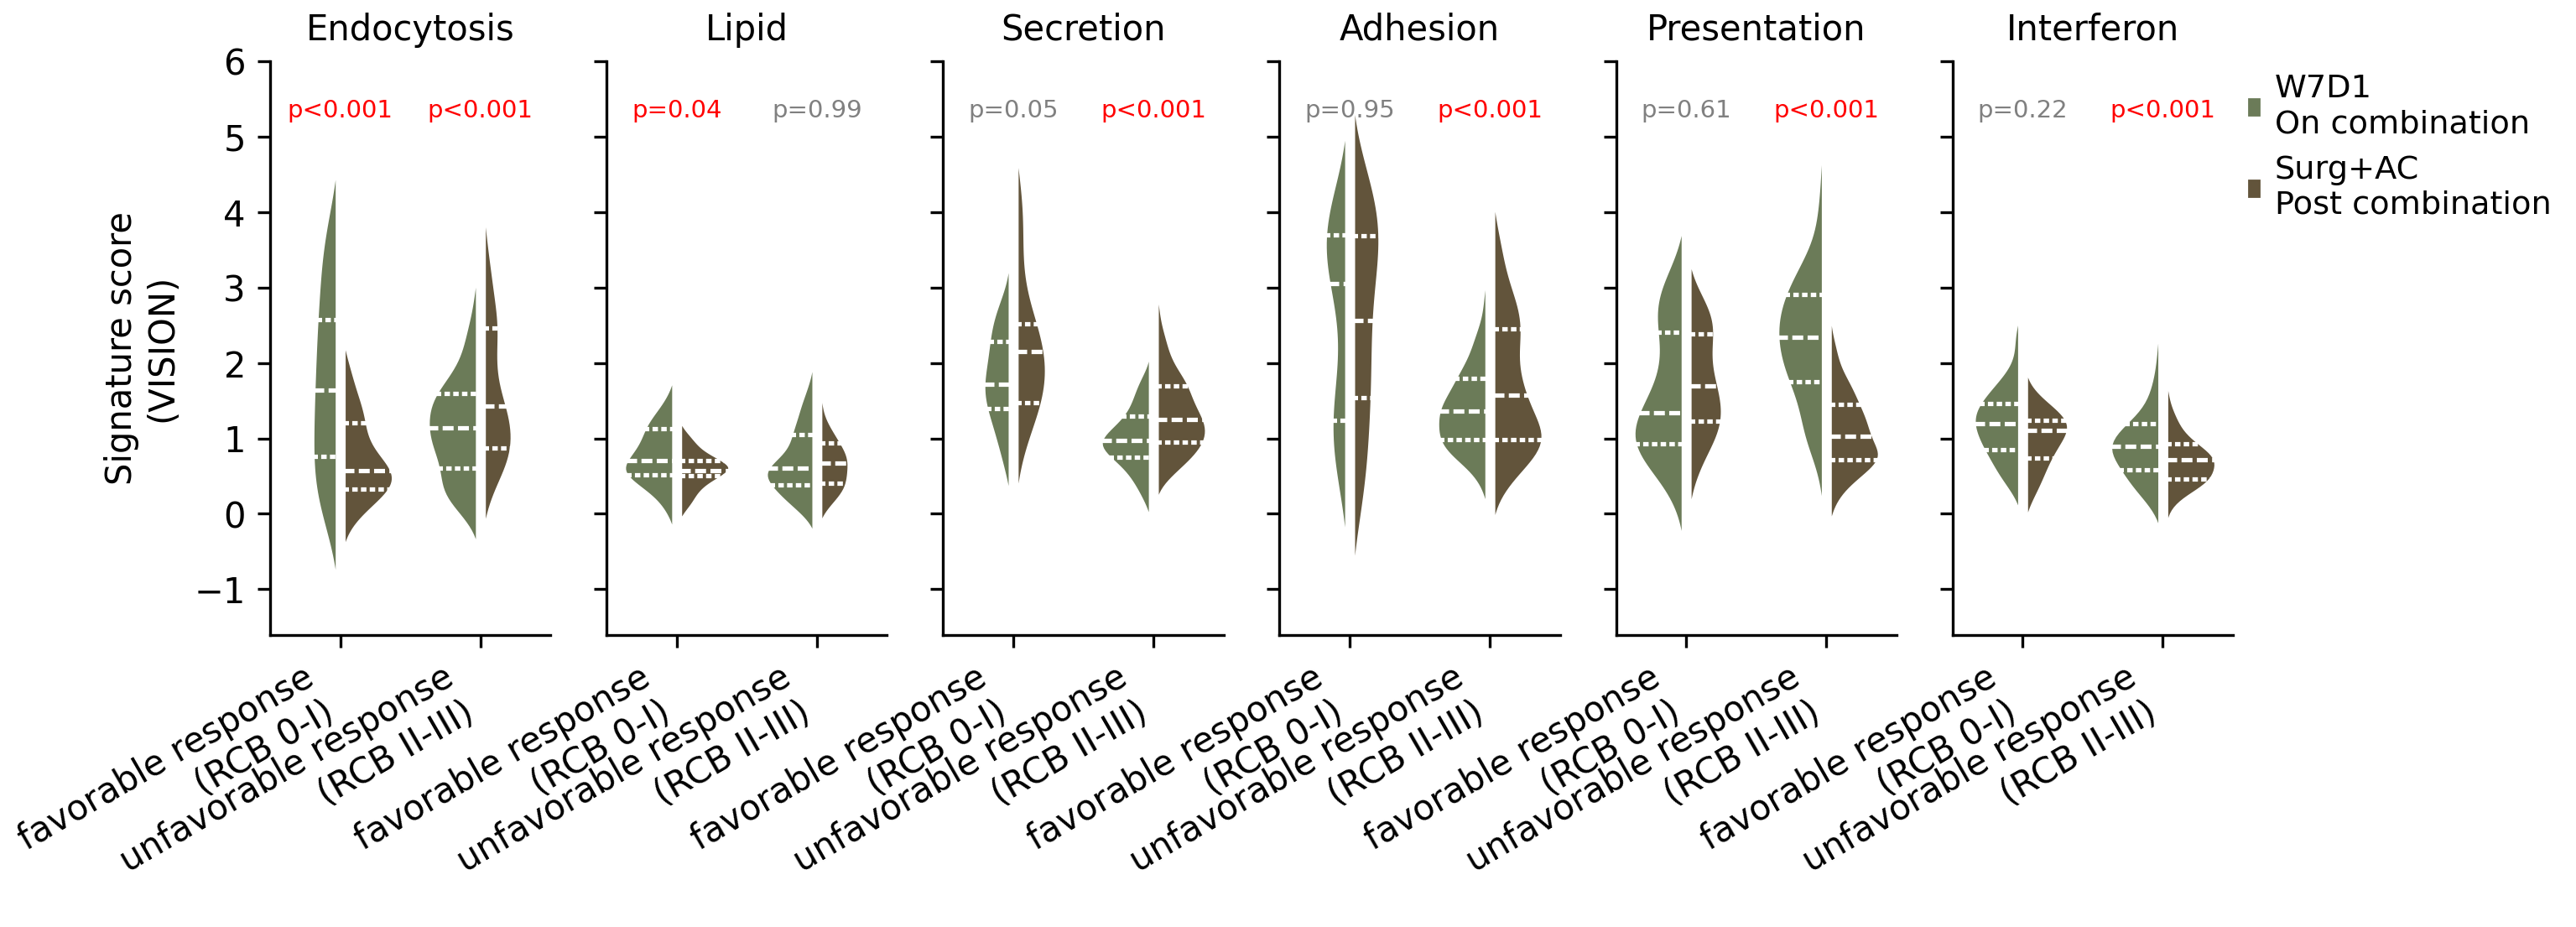

In [125]:
pvalues = result.set_index(['Y',explored_z])['Pvalue']
plt_dt = dt.rename(columns=MP_anno_map)
fig,axs=plt.subplots(1,6,dpi=150,sharey=True,figsize=(10,3))
for i,subtype in enumerate(show_mps):
    ax=axs[i]
    sns.violinplot(data=plt_dt,
                  x='BestResponse',y=subtype,hue='Timepoint',
                  ax=ax,
                  split=True, gap=.1, inner="quart",linecolor='white',
                  palette=COLOR_PAlETTE['Timepoint'])

    ## Add pvalue
    y_loc =5.5
    for xtick in ax.get_xticklabels():
        x_loc,_ = xtick.get_position()
        text = xtick.get_text()
        if pvalues[subtype,text] >= 0.05:
            c='gray'
            label = f"p={pvalues[subtype,text]:.2f}"
        elif pvalues[subtype,text] >= 0.01:
            label = f"p={pvalues[subtype,text]:.2f}"
            c = 'red'
        elif pvalues[subtype,text] >= 0.001:
            label = f"p={pvalues[subtype,text]:.3f}"
            c = 'red'
        else:
            label = "p<0.001"
            c = 'red'
        ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
    ### rename legend label
    if i !=5:
        ax.legend_.remove()
    else:
        handles, previous_labels = ax.get_legend_handles_labels()
        new_labels = [ {'W7D1':'W7D1\nOn combination',
                        'Surg+AC':'Surg+AC\nPost combination'}[text]for text in previous_labels]
        ax.legend(loc=(1,.7),handles=handles, labels=new_labels)
    ax.set(xlabel='',title=subtype,ylabel='Signature score\n(VISION)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

## On surgery - post treatment

In [126]:
x='Timepoint'
explored_z='BestResponse'
random_var='Patient'
dt = scores.loc[(scores.Timepoint.isin(['W7D1','AfterSurg'])),:].copy()
## subsets pts with samples biopsied at both timepoint
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
## perform linear mixture model test
dt[x] = pd.Categorical(dt[x],['W7D1','AfterSurg'],ordered=True)
print(dt.groupby(explored_z)[random_var].nunique())
dt[explored_z] = dt[explored_z].astype(str)
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var).drop_duplicates(['Y','BestResponse'])
result.Y =  result.Y.map(MP_anno_map)
result

BestResponse
favorable response\n(RCB 0-I)         1
unfavorable response\n(RCB II-III)    0
Name: Patient, dtype: int64


Ctrl Experiment             Y      Coef    log2FC                  Pvalue  \
0  W7D1  AfterSurg   Endocytosis -0.443148 -0.257522    0.048945747884610126   
0  W7D1  AfterSurg    Interferon -0.023863 -0.032034       0.787604612813229   
0  W7D1  AfterSurg     Secretion  0.091328  0.084062     0.44509952530464003   
0  W7D1  AfterSurg  Presentation  0.619551  0.481646   6.775116621293245e-07   
0  W7D1  AfterSurg         Lipid  0.543001  0.725526    9.85528908013409e-14   
0  W7D1  AfterSurg      Adhesion  2.030913  1.345312  1.5854240581499392e-43   

                    BestResponse       FDR  
0  favorable response\n(RCB 0-I)  0.073419  
0  favorable response\n(RCB 0-I)  0.787605  
0  favorable response\n(RCB 0-I)  0.534119  
0  favorable response\n(RCB 0-I)  0.000001  
0  favorable response\n(RCB 0-I)       0.0  
0  favorable response\n(RCB 0-I)       0.0

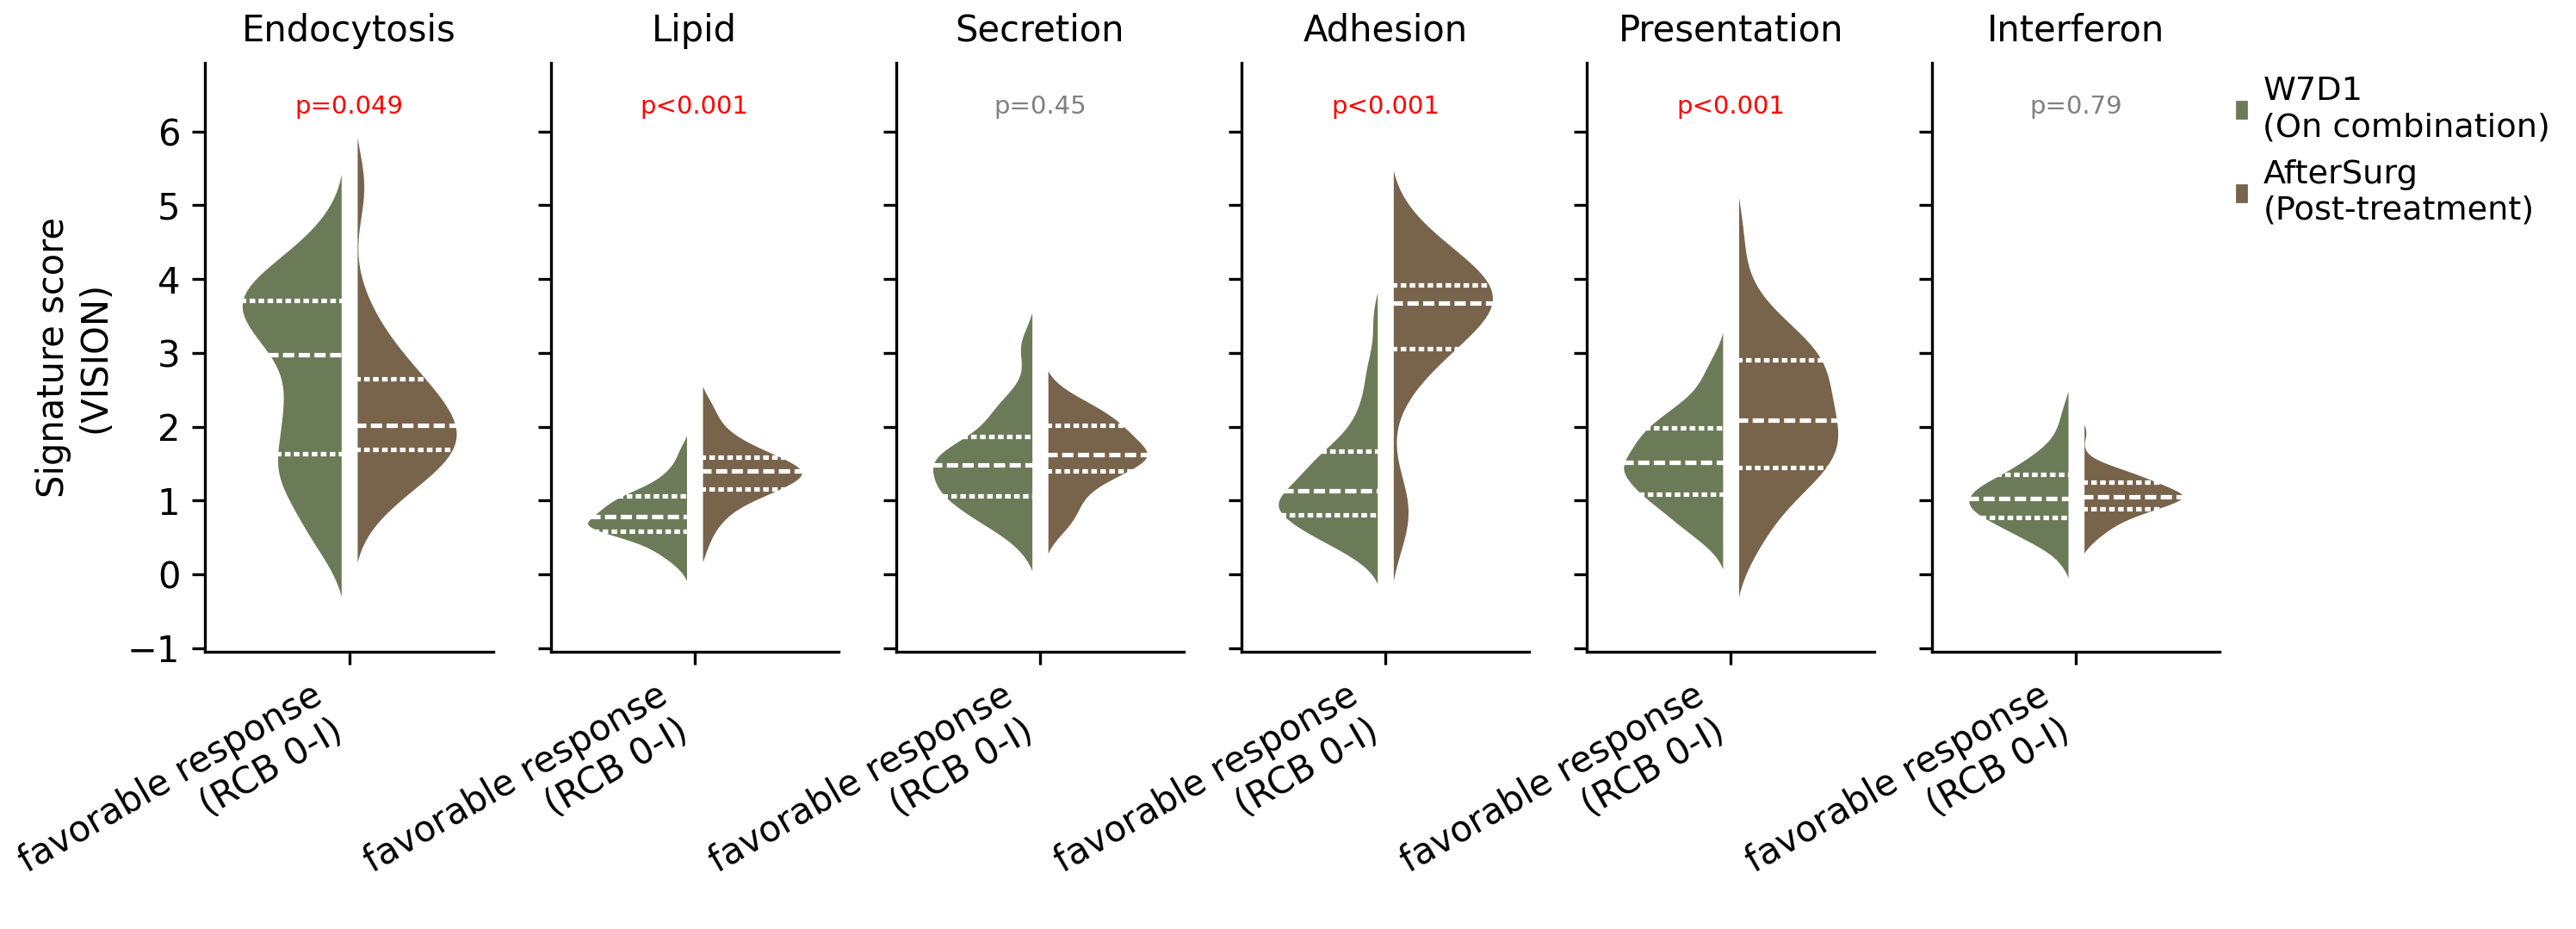

In [127]:
pvalues = result.set_index(['Y',explored_z])['Pvalue']
plt_dt = dt.rename(columns=MP_anno_map)
fig,axs=plt.subplots(1,6,dpi=150,sharey=True,figsize=(10,3))
for i,subtype in enumerate(show_mps):
    ax=axs[i]
    sns.violinplot(data=plt_dt,
                  x='BestResponse',y=subtype,hue='Timepoint',
                  ax=ax,
                  split=True, gap=.1, inner="quart",linecolor='white',
                  palette=COLOR_PAlETTE['Timepoint'])

    ## Add pvalue
    y_loc =6.5
    for xtick in ax.get_xticklabels():
        x_loc,_ = xtick.get_position()
        text = xtick.get_text()
        if pvalues[subtype,text] >= 0.05:
            c='gray'
            label = f"p={pvalues[subtype,text]:.2f}"
        elif pvalues[subtype,text] >= 0.01:
            label = f"p={pvalues[subtype,text]:.3f}"
            c = 'red'
        elif pvalues[subtype,text] >= 0.001:
            label = f"p={pvalues[subtype,text]:.3f}"
            c = 'red'
        else:
            label = "p<0.001"
            c = 'red'
        ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
    ### rename legend label
    if i !=5:
        ax.legend_.remove()
    else:
        handles, previous_labels = ax.get_legend_handles_labels()
        new_labels = [ {'W7D1':'W7D1\n(On combination)',
                        'AfterSurg':'AfterSurg\n(Post-treatment)'}[text]for text in previous_labels]
        ax.legend(loc=(1,.7),handles=handles, labels=new_labels)
    ax.set(xlabel='',title=subtype,ylabel='Signature score\n(VISION)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

# Theray induced changes 

In [45]:
results = {}
random_var='Patient'

## Chemotherapy

In [46]:
x='Timepoint'
explored_z=None
random_var='Patient'
dt = scores.loc[(scores.Timepoint.isin(['Baseline','W3D1']))&
                (scores.Treatment_Arm=='Chemo->Combo'),:].copy()
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
dt.groupby([x])[random_var].nunique().rename('N_Pts').reset_index()

Timepoint  N_Pts
0  AfterSurg      0
1   Baseline      2
2    Surg+AC      0
3       W3D1      2
4       W7D1      0

In [47]:
dt[x] = pd.Categorical(dt[x],['Baseline','W3D1'],ordered=True)
result = lmTest(dt=dt,Y=Y,x=x,Z=[],explored_z=explored_z,random_var=random_var)
result.Y =  result.Y.map(MP_anno_map)
results['Chemo'] = result
result

Ctrl Experiment             Y      Coef    log2FC  \
0  Baseline       W3D1      Adhesion  0.072379  0.039188   
0  Baseline       W3D1         Lipid  0.060434  0.085525   
0  Baseline       W3D1  Presentation  0.460073  0.261146   
0  Baseline       W3D1   Endocytosis  0.290022  0.322623   
0  Baseline       W3D1    Interferon  0.387687  0.417662   
0  Baseline       W3D1     Secretion  0.354123  0.418141   

                   Pvalue       FDR  
0     0.02762402810375548  0.033149  
0     0.11641185425605226  0.116412  
0   1.915679077935436e-25       0.0  
0  2.8833052966491813e-13       0.0  
0  1.1606160018116886e-27       0.0  
0   7.003148189045898e-38       0.0

## Pembro

In [48]:
x='Timepoint'
explored_z=None
random_var='Patient'
dt = scores.loc[(scores.Timepoint.isin(['Baseline','W3D1']))&
                (scores.Treatment_Arm=='ICI->Combo'),:].copy()
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
dt.groupby([x])[random_var].nunique().rename('N_Pts').reset_index()

Timepoint  N_Pts
0  AfterSurg      0
1   Baseline      3
2    Surg+AC      0
3       W3D1      3
4       W7D1      0

In [49]:
dt[x] = pd.Categorical(dt[x],['Baseline','W3D1'],ordered=True)
result = lmTest(dt=dt,Y=Y,x=x,Z=[],explored_z=explored_z,random_var=random_var)
result.Y =  result.Y.map(MP_anno_map)
results['Pembro'] = result
result

Ctrl Experiment             Y      Coef    log2FC  \
0  Baseline       W3D1   Endocytosis -0.259663 -0.420072   
0  Baseline       W3D1         Lipid -0.053036 -0.169441   
0  Baseline       W3D1      Adhesion  0.120779  0.047046   
0  Baseline       W3D1  Presentation  0.203133  0.193835   
0  Baseline       W3D1     Secretion  0.237331  0.204705   
0  Baseline       W3D1    Interferon  0.285555  0.437299   

                   Pvalue       FDR  
0  1.8276531412923458e-07       0.0  
0     0.24435031541307506   0.24435  
0    0.045349890278479146   0.05442  
0   0.0064205360510128035  0.009631  
0  5.0679706314050747e-08       0.0  
0  1.7995854943891648e-10       0.0

### Adjuvant Combo

In [50]:
x='Timepoint'
explored_z=None
random_var='Patient'
dt = scores.loc[(scores.Timepoint.isin(['W3D1','W7D1'])),:].copy()
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
dt.groupby([x])[random_var].nunique().rename('N_Pts').reset_index()

Timepoint  N_Pts
0  AfterSurg      0
1   Baseline      0
2    Surg+AC      0
3       W3D1      5
4       W7D1      5

In [51]:
dt[x] = pd.Categorical(dt[x],['W3D1','W7D1'],ordered=True)
result = lmTest(dt=dt,Y=Y,x=x,Z=[],explored_z=explored_z,random_var=random_var)
result.Y =  result.Y.map(MP_anno_map)
results['Combination'] = result
result

Ctrl Experiment             Y      Coef    log2FC                  Pvalue  \
0  W3D1       W7D1      Adhesion -0.367131 -0.273008   7.753807287659437e-70   
0  W3D1       W7D1     Secretion -0.133226 -0.179905  1.3431207350817892e-11   
0  W3D1       W7D1    Interferon -0.194154 -0.178867  2.6109823711903668e-12   
0  W3D1       W7D1  Presentation -0.080035  0.060324    0.022196809631160223   
0  W3D1       W7D1   Endocytosis  0.179877  0.256432  1.6775493064868365e-11   
0  W3D1       W7D1         Lipid  0.520906  0.656252  1.3803321537327749e-67   

        FDR  
0       0.0  
0       0.0  
0       0.0  
0  0.022197  
0       0.0  
0       0.0

## Visualize the effect

In [52]:
dt = []
for k,v in results.items():
    tmp = v.copy()
    tmp['Comparison'] = k
    dt.append(tmp)
dt=pd.concat(dt,axis=0,ignore_index=True)
palette = {k.replace('Macs.',''):v for k,v in COLOR_PAlETTE['Cellstate'].items() if 'Macs' in k}
dt.head()

Ctrl Experiment             Y      Coef    log2FC  \
0  Baseline       W3D1      Adhesion  0.072379  0.039188   
1  Baseline       W3D1         Lipid  0.060434  0.085525   
2  Baseline       W3D1  Presentation  0.460073  0.261146   
3  Baseline       W3D1   Endocytosis  0.290022  0.322623   
4  Baseline       W3D1    Interferon  0.387687  0.417662   

                   Pvalue       FDR Comparison  
0     0.02762402810375548  0.033149      Chemo  
1     0.11641185425605226  0.116412      Chemo  
2   1.915679077935436e-25       0.0      Chemo  
3  2.8833052966491813e-13       0.0      Chemo  
4  1.1606160018116886e-27       0.0      Chemo

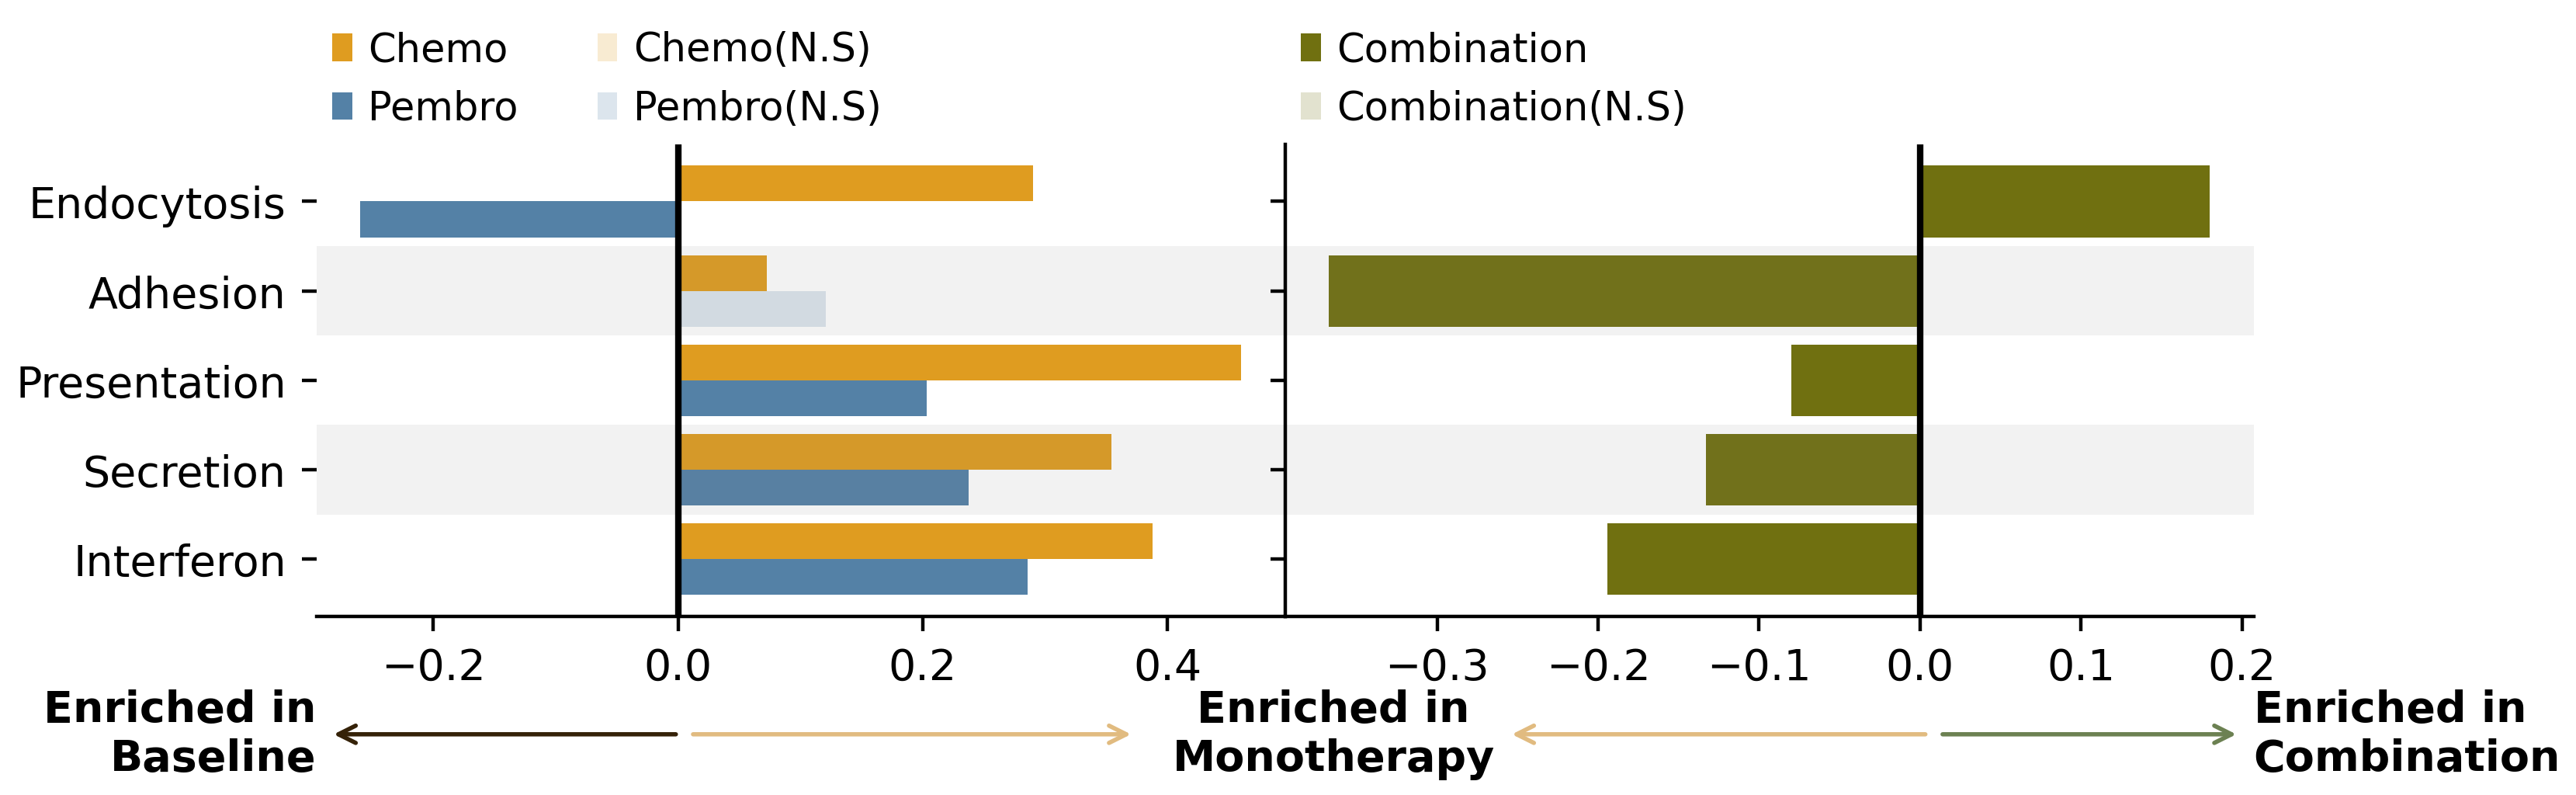

In [54]:
fig,axs=plt.subplots(1,2,figsize=(8,2),sharey=True,dpi=200)
ax =axs[0]
sig_y = dt.Y[dt.Comparison.isin(['Chemo','Pembro']) & (dt.FDR<0.05)].unique()
sub_dt = dt.loc[dt.Comparison.isin(['Chemo','Pembro']) & dt.Y.isin(sig_y),:].copy()
order = sub_dt.sort_values('Coef').Y

sns.barplot(data=sub_dt.loc[sub_dt['FDR']<0.05,:],x='Coef',y='Y',hue='Comparison',ax=ax,palette={'Chemo':'orange','Pembro':'steelblue'},order=order)

sub_dt.loc[sub_dt['FDR']<0.05,'Coef']=0
sub_dt['non_sig'] = sub_dt['Comparison']+"(N.S)"
sns.barplot(data=sub_dt,x='Coef',y='Y',hue='non_sig',ax=ax,palette={'Chemo(N.S)':'orange','Pembro(N.S)':'steelblue'},order=order,alpha=.2)
ax.legend(loc=(0,1),ncols=2)

ax.set(ylabel='',xlabel='')#Coefficient: W3D1-Baseline')
ax.grid(False)
ax.axvline(x=0,color='k')
ax.spines['left'].set_visible(False)
center=.38
name =''
ax.annotate(name, xy=(center, -0.25), xycoords='axes fraction', xytext=(0.85, -0.25), 
            arrowprops=dict(arrowstyle="<-", color=COLOR_PAlETTE['Timepoint']['W3D1']),ha='center',va='center')
name ='Enriched in\nBaseline'
ax.annotate(name, xy=(center, -0.25), xycoords='axes fraction', xytext=(0, -0.25), 
            arrowprops=dict(arrowstyle="<-",  color=COLOR_PAlETTE['Timepoint']['Baseline']),ha='right',va='center',weight='bold')
ax.axhspan(.5, 1.5, facecolor='gray', alpha=0.1)
ax.axhspan(2.5, 3.5, facecolor='gray', alpha=0.1)

ax =axs[1]
# sig_y = dt.Y[dt.Comparison.isin(['Combination']) & (dt.FDR<0.05)].unique()
sub_dt = dt.loc[dt.Comparison.isin(['Combination']) & dt.Y.isin(sig_y),:].copy()
sns.barplot(data=sub_dt.loc[sub_dt['FDR']<0.05,:],x='Coef',y='Y',ax=ax,color='olive',order=order,label='Combination')

sub_dt.loc[sub_dt['FDR']<0.05,'Coef']=0
sub_dt['non_sig'] = sub_dt['Comparison']+"(N.S)"
sns.barplot(data=sub_dt,x='Coef',y='Y',ax=ax,color='olive',order=order,alpha=.2,label='Combination(N.S)')

ax.legend(loc=(0,1),ncols=1)
ax.set(ylabel='',xlabel='')#Coefficient: W7D1-W3D1')
ax.grid(False)
# ax.spines['left'].set_visible(False)
ax.axvline(x=0,color='k')
plt.subplots_adjust(wspace=0)
center=.67
name ='Enriched in\nCombination'
ax.annotate(name, xy=(center, -0.25), xycoords='axes fraction', xytext=(1, -0.25), 
            arrowprops=dict(arrowstyle="<-", color=COLOR_PAlETTE['Timepoint']['W7D1']),ha='left',va='center',weight='bold')
name ='Enriched in\nMonotherapy'
ax.annotate(name, xy=(center, -0.25), xycoords='axes fraction', xytext=(0.05, -0.25), 
            arrowprops=dict(arrowstyle="<-",  color=COLOR_PAlETTE['Timepoint']['W3D1']),ha='center',va='center',weight='bold')

ax.axhspan(.5, 1.5, facecolor='gray', alpha=0.1)
ax.axhspan(2.5, 3.5, facecolor='gray', alpha=0.1)
# ax.axhspan(.5, 1.5, facecolor='gray', alpha=0.25)
plt.savefig(f"{FIGURE_FOLDER}/Macs_MPs_over_treatment.pdf",dpi=200)

# Paired patients - R vs NR

## All

In [63]:
x='Timepoint'
explored_z='Treatment_Arm'
random_var='Patient'
dt = scores.loc[scores.Timepoint.isin(['Baseline','W7D1']),:].copy()
# paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
# paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
dt.groupby([x,'Treatment_Arm'])[random_var].nunique().rename('N_Pts').reset_index()

Timepoint Treatment_Arm  N_Pts
0  AfterSurg  Chemo->Combo      0
1  AfterSurg    ICI->Combo      0
2   Baseline  Chemo->Combo      2
3   Baseline    ICI->Combo      3
4    Surg+AC  Chemo->Combo      0
5    Surg+AC    ICI->Combo      0
6       W3D1  Chemo->Combo      0
7       W3D1    ICI->Combo      0
8       W7D1  Chemo->Combo      2
9       W7D1    ICI->Combo      3

In [64]:
dt[x] = pd.Categorical(dt[x],['Baseline','W7D1'],ordered=True)
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[explored_z],explored_z=explored_z,random_var=random_var)
significant_MP = result.Y[(result.Pvalue<0.05)&(result[f'log2FC'].abs()>.5)].unique().tolist()
result.Y =  result.Y.map(MP_anno_map)
result = result.loc[result.Treatment_Arm.str.contains('\+'),:]
result

Ctrl Experiment             Y      Coef    log2FC  \
0  Baseline       W7D1      Adhesion -0.319331 -0.389403   
0  Baseline       W7D1     Secretion  -0.02987 -0.303952   
0  Baseline       W7D1   Endocytosis  0.139809  -0.01171   
0  Baseline       W7D1  Presentation  0.257468   0.32471   
0  Baseline       W7D1    Interferon  0.387257  0.429064   
0  Baseline       W7D1         Lipid   0.79084  1.016346   

                    Pvalue            Treatment_Arm       FDR  
0    2.367741273472699e-36  Chemo->Combo+ICI->Combo       0.0  
0      0.13215243488549286  Chemo->Combo+ICI->Combo  0.132152  
0   3.9321961340758553e-07  Chemo->Combo+ICI->Combo       0.0  
0    1.642794138935683e-17  Chemo->Combo+ICI->Combo       0.0  
0    7.670500458454264e-59  Chemo->Combo+ICI->Combo       0.0  
0  2.7553802426432262e-176  Chemo->Combo+ICI->Combo       0.0

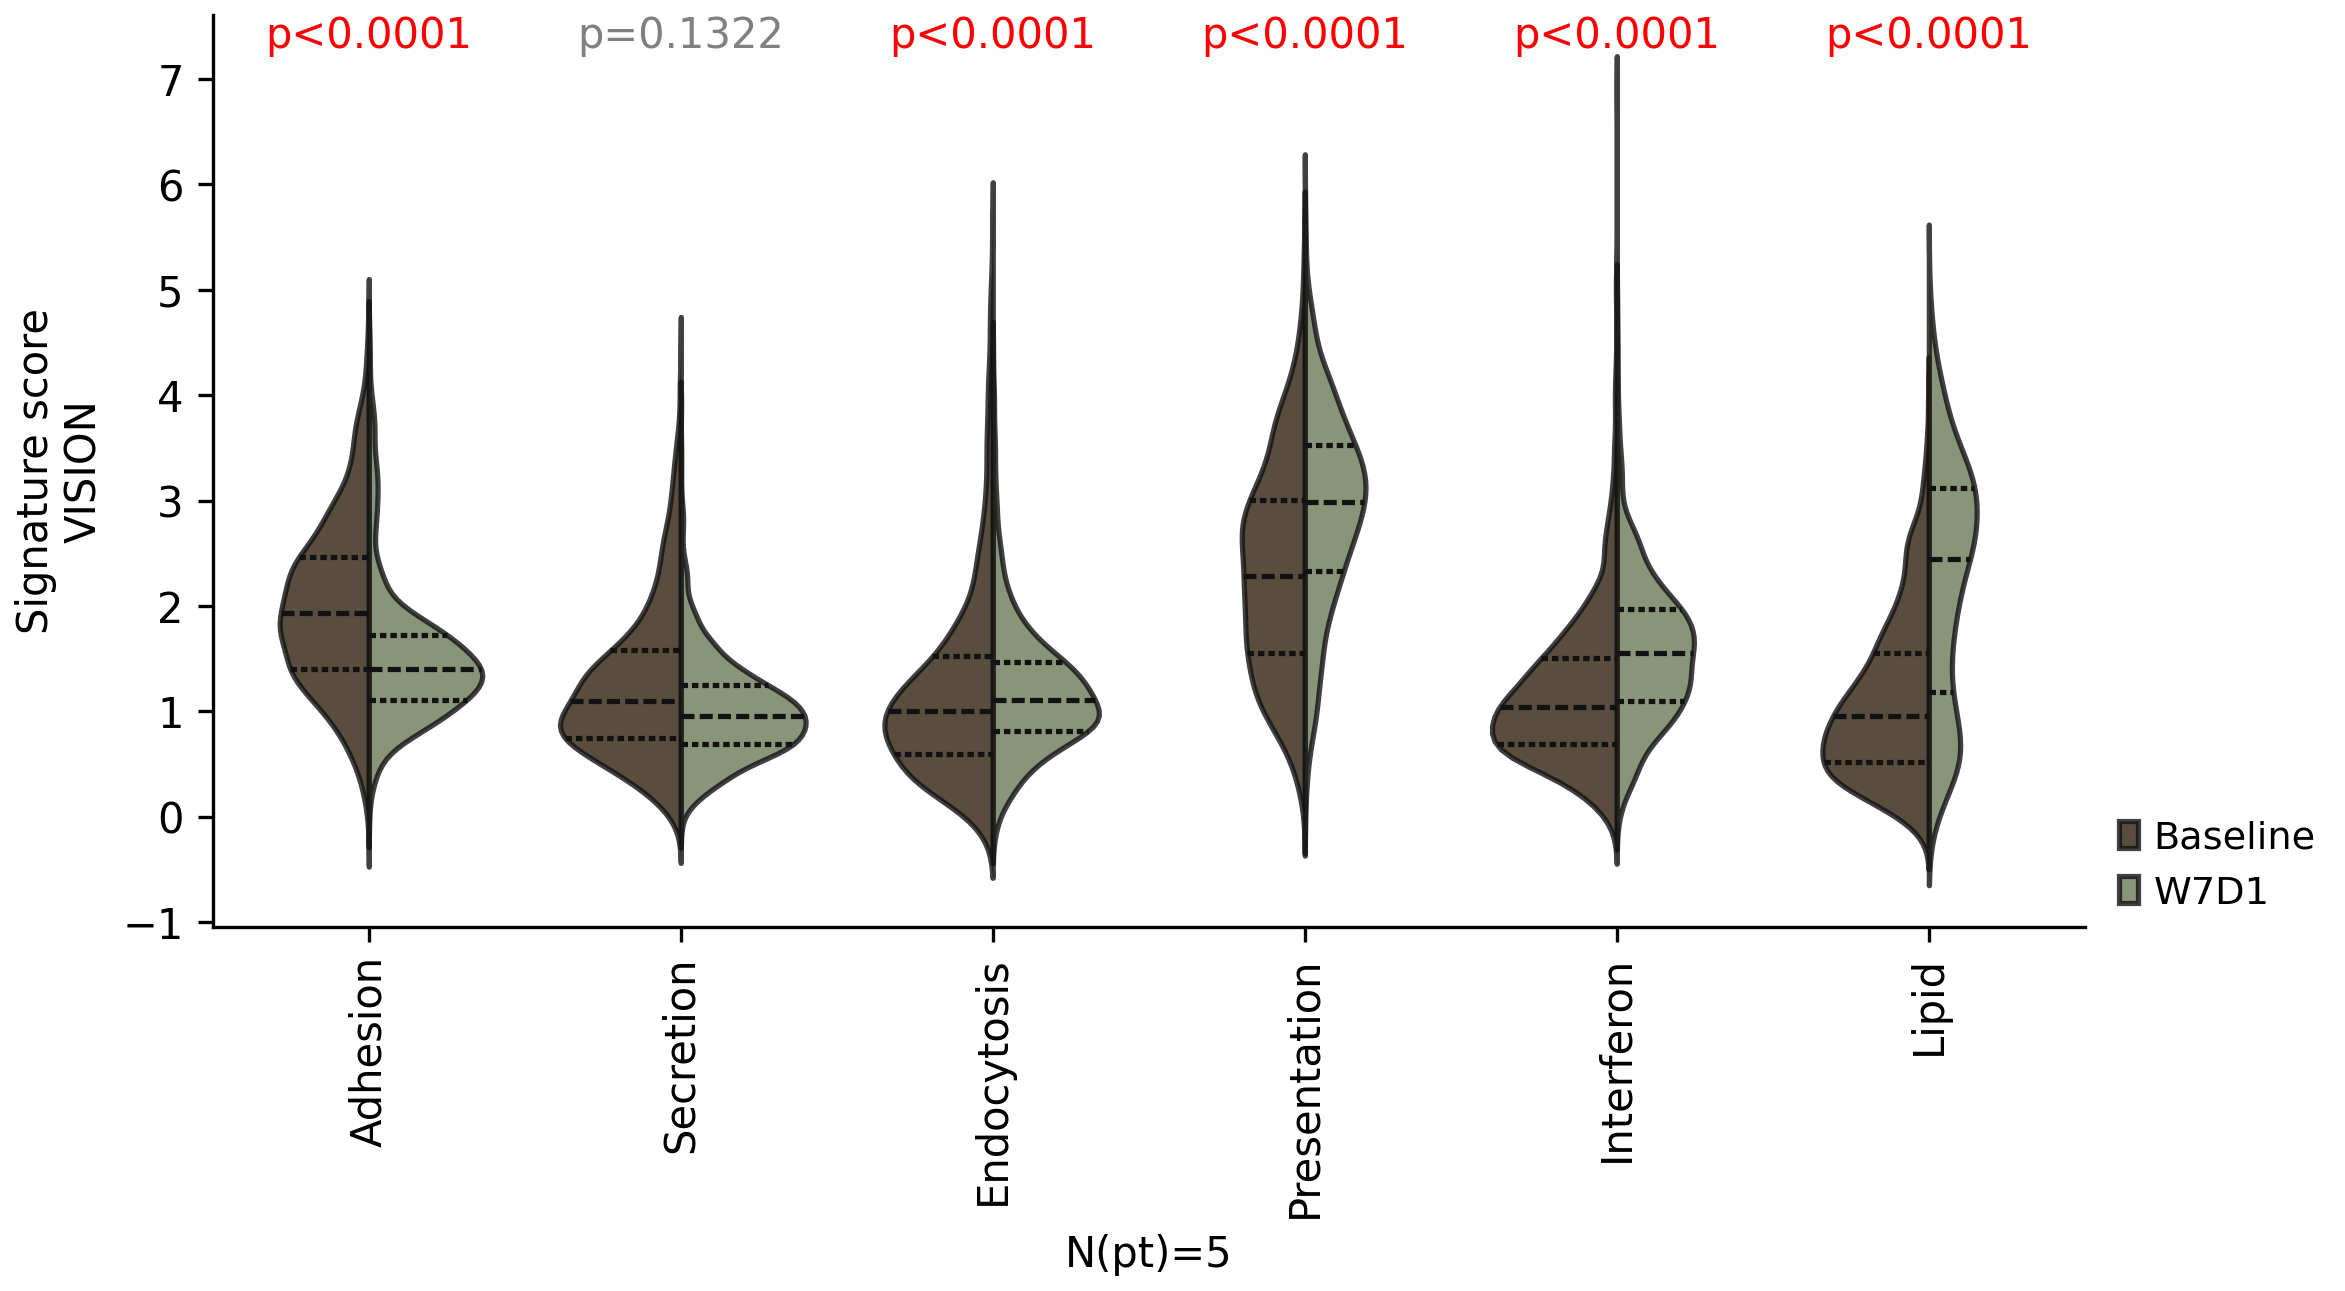

In [65]:
# show_mps = result.loc[(result.Pvalue<0.05)&(result[f'Coef'].abs()>.2),:].sort_values('log2FC').Y.tolist()
show_mps = result.sort_values('Coef').Y.unique().tolist()
pvalues = result.loc[(result.Y.isin(show_mps)),:].set_index('Y')['Pvalue']
dt.rename(columns=MP_anno_map,inplace=True)
fig,ax=plt.subplots(1,1,figsize=(8,4),dpi=150)
sns.violinplot(data=dt[show_mps+[x]].melt(id_vars=[x]),
                   ax=ax,
                x='variable',y='value',hue=x,
                   # showfliers=False,
                split=True,inner="quart", fill=True,
                palette=COLOR_PAlETTE[x],alpha=.8)
y_loc =ax.get_ylim()[1]
for xtick in ax.get_xticklabels():
    x_loc,_ = xtick.get_position()
    text = xtick.get_text()
    label = f"p={pvalues[text]:.4f}" if pvalues[text] >= 0.0001 else "p<0.0001"
    if pvalues[text] >= 0.05:
        c='gray'
    else:
        c = 'red'
    ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c)
ax.set(xlabel=f"N(pt)={dt['Patient'].nunique()}",ylabel=f"Signature score\n{signature_method}")
ax.legend(loc=(1.01,0),frameon=False,ncol=1)
ax.spines[['right','top']].set_visible(False);
ax.tick_params(axis='x',rotation=90)

# Changes W3D1 - W7D1

## Non-responder

In [76]:
x='Timepoint'
explored_z=None
random_var='Patient'
dt = scores.loc[scores.Timepoint.isin(['W3D1','W7D1'])&
                (scores.BestResponse=='II-III'),:].copy()
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
dt.groupby([x,'Treatment_Arm'])[random_var].nunique().rename('N_Pts').reset_index()

Timepoint Treatment_Arm  N_Pts
0  AfterSurg  Chemo->Combo      0
1  AfterSurg    ICI->Combo      0
2   Baseline  Chemo->Combo      0
3   Baseline    ICI->Combo      0
4    Surg+AC  Chemo->Combo      0
5    Surg+AC    ICI->Combo      0
6       W3D1  Chemo->Combo      1
7       W3D1    ICI->Combo      2
8       W7D1  Chemo->Combo      1
9       W7D1    ICI->Combo      2

In [77]:
dt[x] = pd.Categorical(dt[x],['W3D1','W7D1'],ordered=True)
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
significant_MP = result.Y[(result.Pvalue<0.05)&(result[f'log2FC'].abs()>.5)].unique().tolist()
result.Y =  result.Y.map(MP_anno_map)
# result = result.loc[result.Treatment_Arm.str.contains('\+'),:]

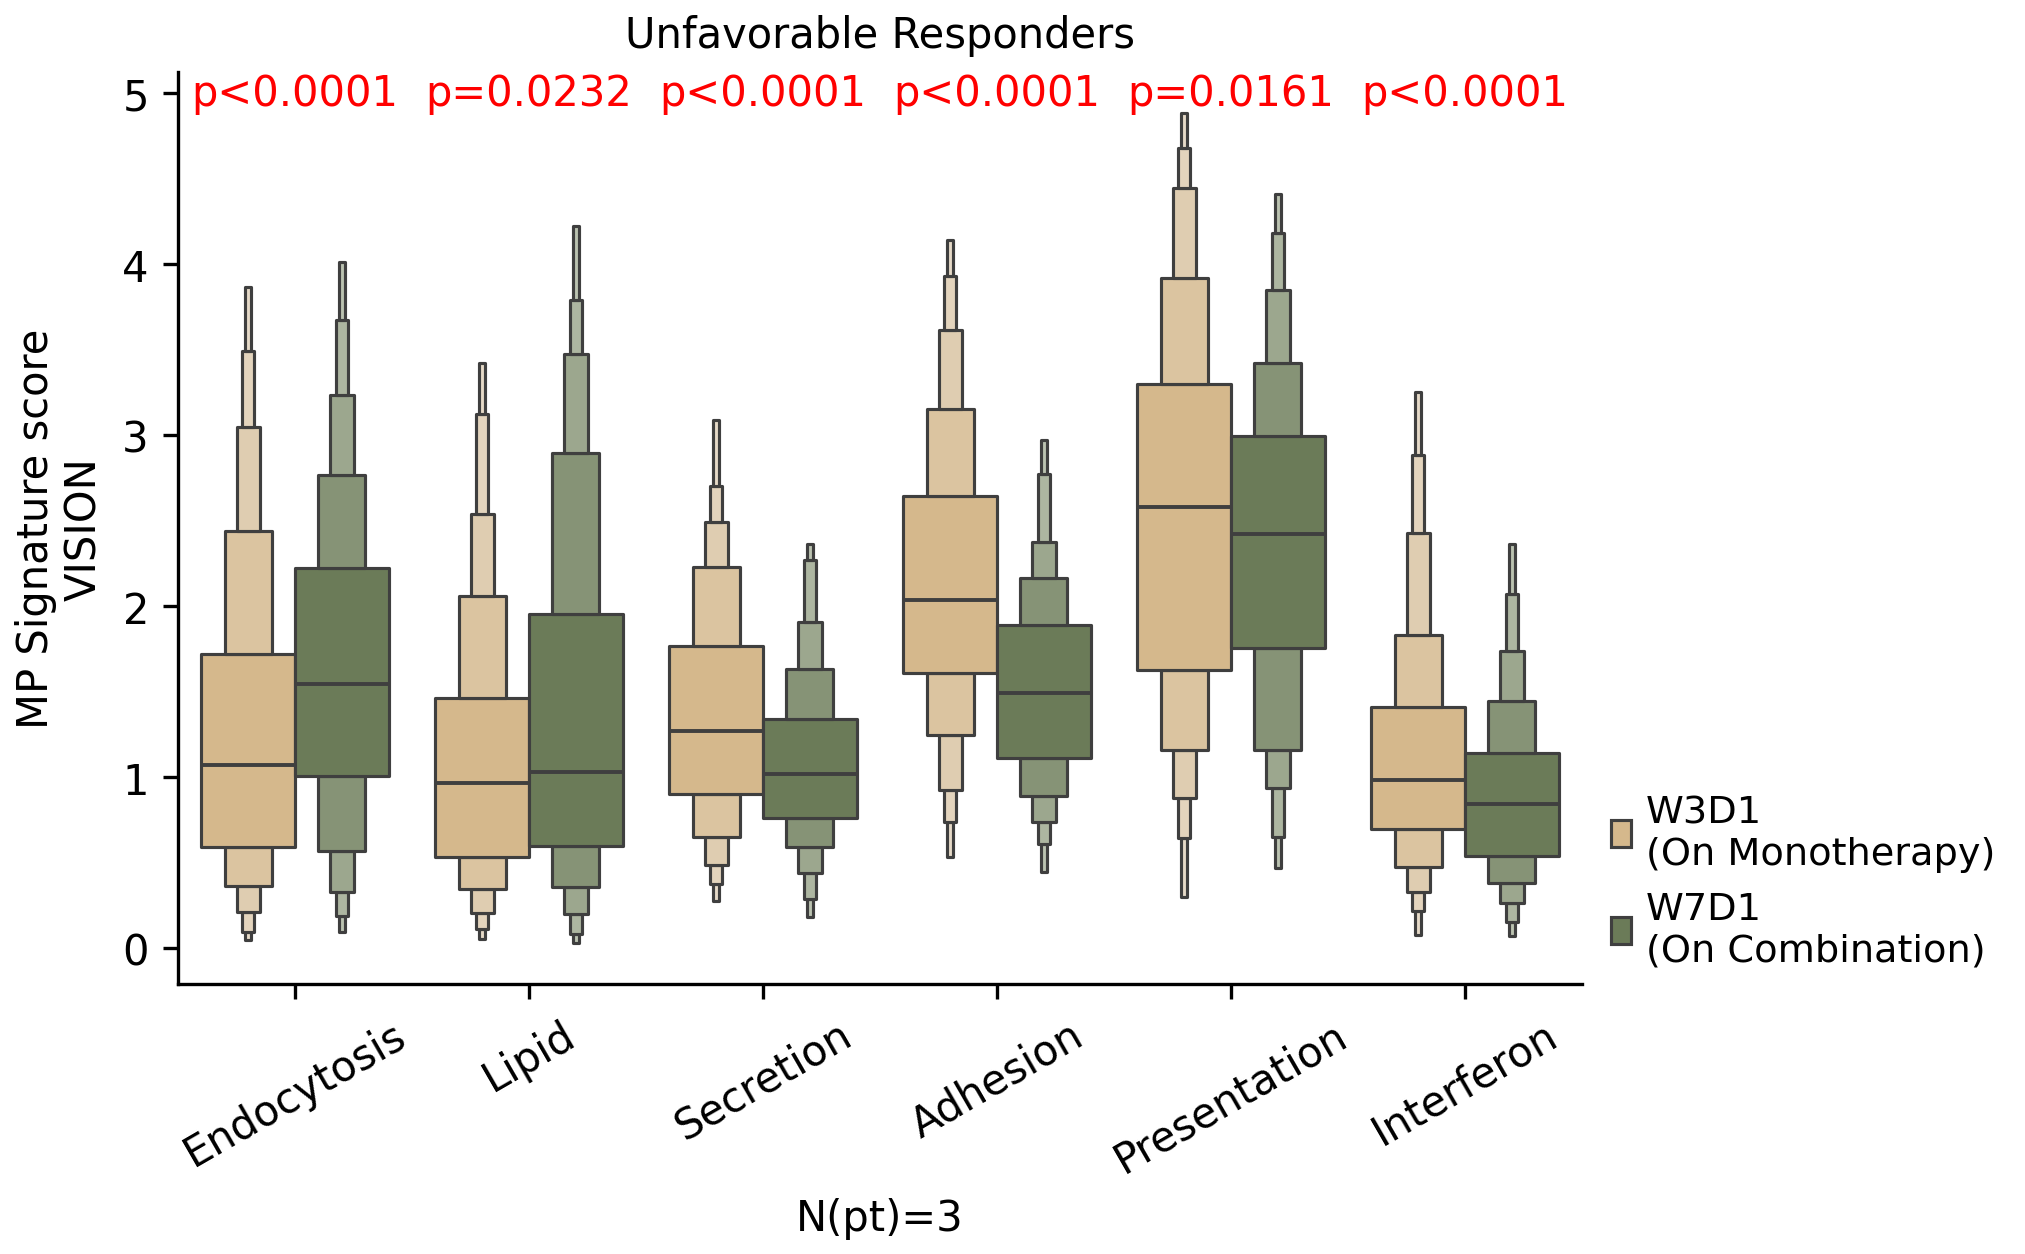

In [78]:
# show_mps = result.loc[(result.Pvalue<0.05)&(result[f'log2FC'].abs()>.5),:].sort_values('log2FC').Y.tolist()
# show_mps= ['Adhesion', 'Interferon', 'Lipid']
# show_mps = ['Endocytosis','Presentation']
# show_mps = list(MP_anno_map.values())
show_mps = ['Endocytosis','Lipid','Secretion','Adhesion','Presentation','Interferon'] # result.sort_values('Coef').Y.unique().tolist()
pvalues = result.loc[(result.Y.isin(show_mps)),:].set_index('Y')['Pvalue']
dt.rename(columns=MP_anno_map,inplace=True)
plot_rename = {'W3D1':'W3D1\n(On Monotherapy)','W7D1':'W7D1\n(On Combination)'}
dt[x] = dt[x].replace(plot_rename)
palette = {}
for k,v in plot_rename.items():
    palette[v] = COLOR_PAlETTE[x][k]
fig,ax=plt.subplots(1,1,figsize=(6,4),dpi=150)
sns.boxenplot(data=dt[show_mps+[x]].melt(id_vars=[x]),
                x='variable',y='value',hue=x,showfliers=False,
                palette=palette,ax=ax)
y_loc =ax.get_ylim()[1]
for xtick in ax.get_xticklabels():
    x_loc,_ = xtick.get_position()
    text = xtick.get_text()
    label = f"p={pvalues[text]:.4f}" if pvalues[text] >= 0.0001 else "p<0.0001"
    if pvalues[text] >= 0.05:
        c='gray'
    else:
        c = 'red'
    ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c)
ax.set(xlabel=f"N(pt)={dt['Patient'].nunique()}",ylabel=f"MP Signature score\n{signature_method}",title='Unfavorable Responders')
ax.legend(loc=(1.01,0),frameon=False,ncol=1)
ax.spines[['right','top']].set_visible(False);
ax.grid(False)
ax.tick_params(axis='x',rotation=30)

In [79]:
from scipy.stats import wilcoxon

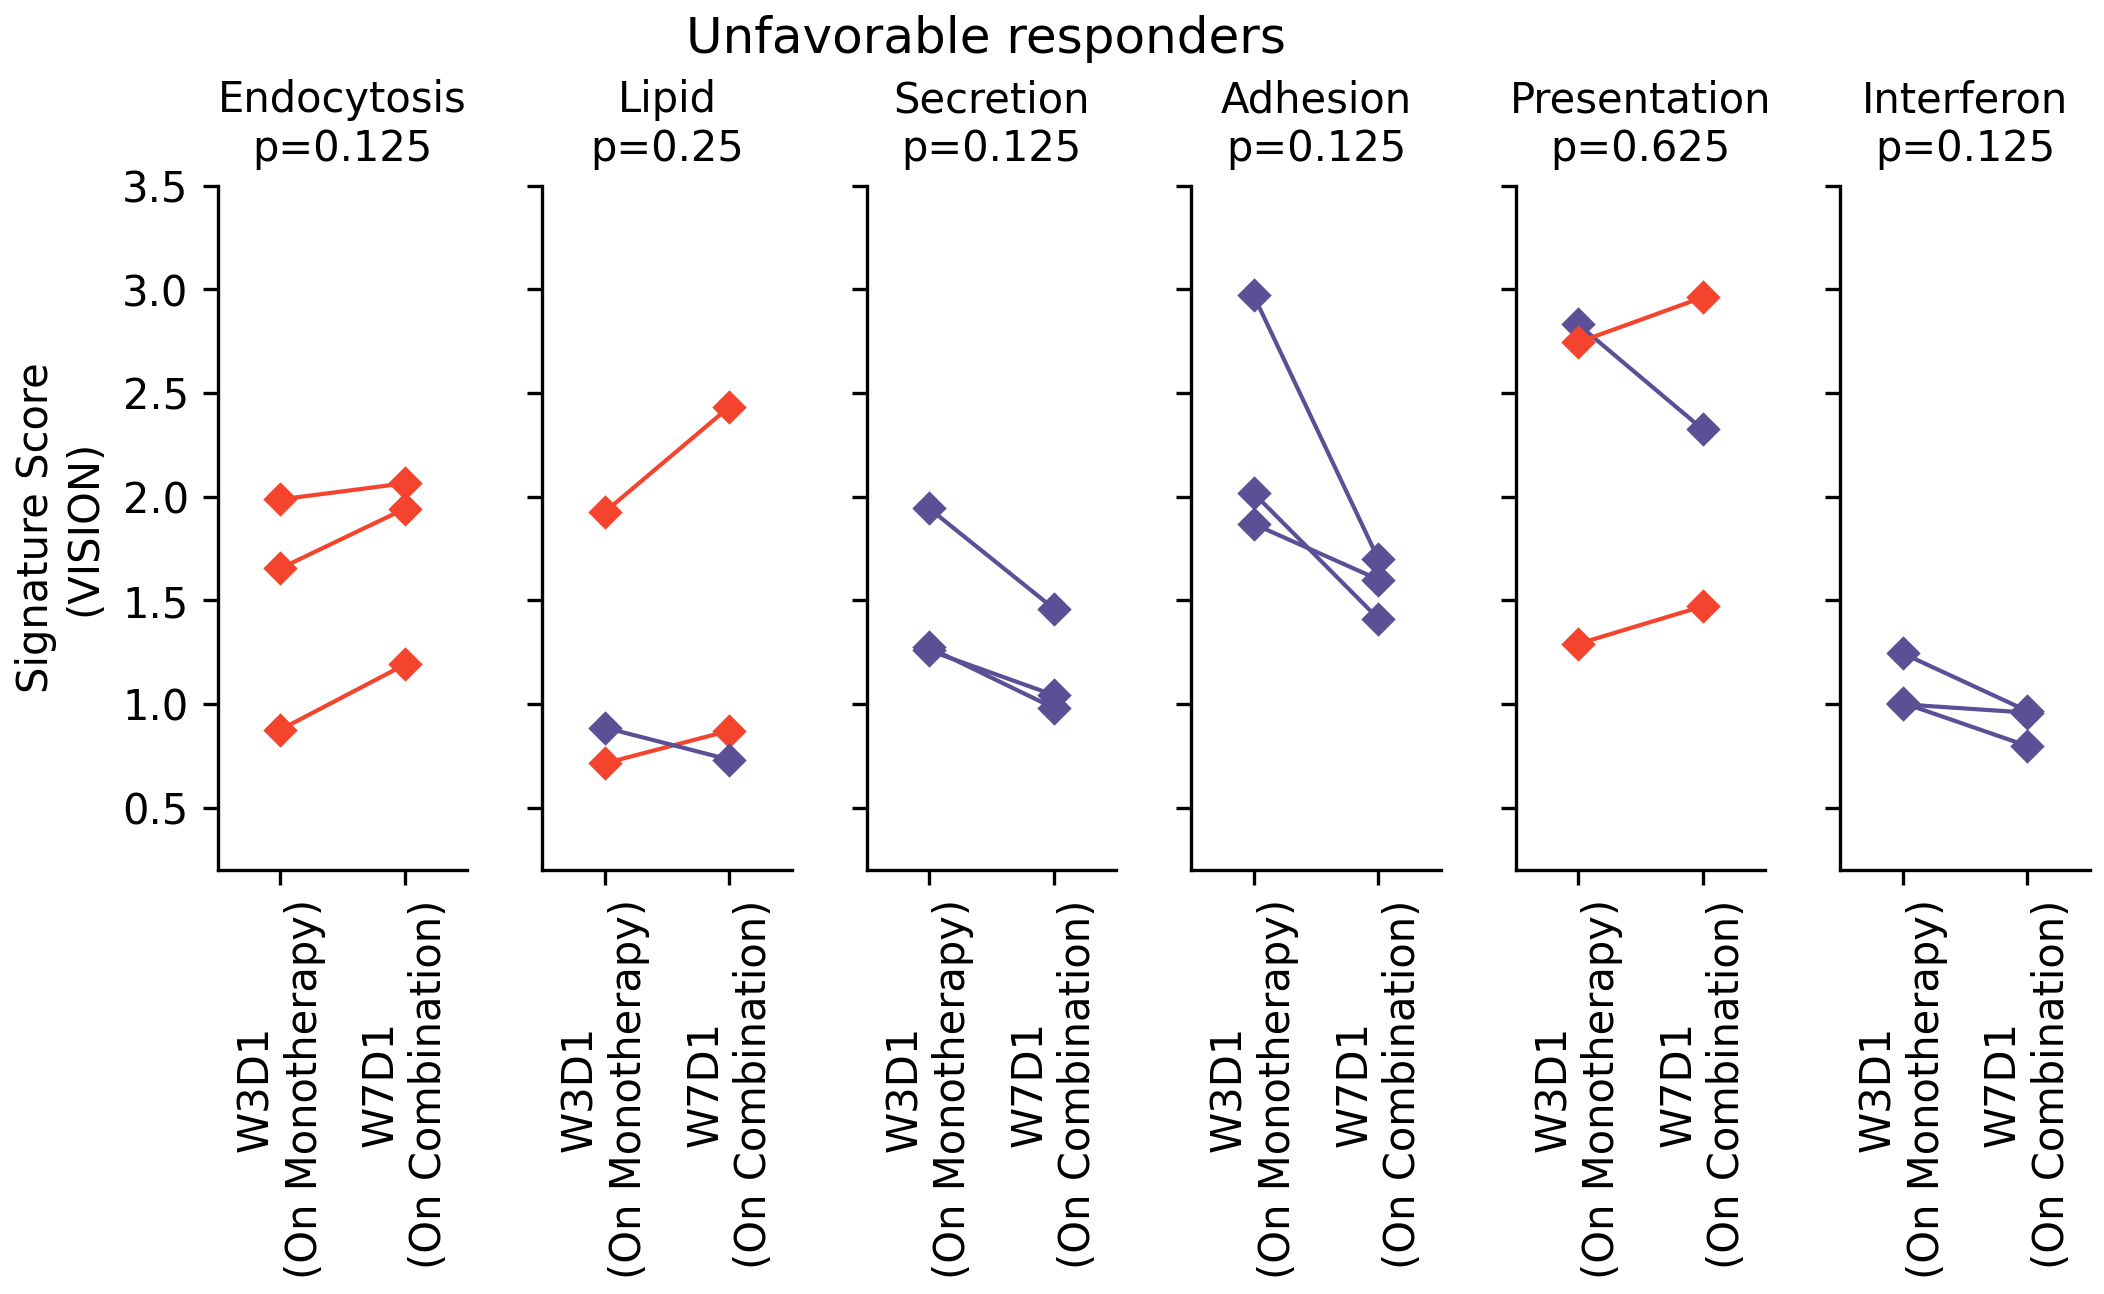

In [80]:
pseudo_dt = dt.groupby(['Patient','Timepoint'])[show_mps].mean().dropna(how='all',axis=0).reset_index()
pseudo_dt.Patient = pseudo_dt.Patient.astype(str)
fig,axs=plt.subplots(1,len(show_mps),figsize=(8,3),dpi=150,sharey=True)
for i,y in enumerate(show_mps):
    ax=axs[i]
    delta = pseudo_dt.pivot_table(index='Patient',columns='Timepoint',values=y).diff(axis=1)['W7D1\n(On Combination)']
    z,p = wilcoxon(delta.values,alternative='greater' if delta.sum()>0 else 'less')
    palette = delta.map(lambda x:"#f4442e" if x >0 else "#5b5095").to_dict()
    # palette = pseudo_dt[['Patient','BestResponse']].drop_duplicates().set_index('Patient')['BestResponse'].map(COLOR_PAlETTE['BestResponse']).to_dict()
    sns.pointplot(data=pseudo_dt,
                   ax=ax,
                  order=['W3D1\n(On Monotherapy)','W7D1\n(On Combination)'],
                  x='Timepoint',y=y,hue='Patient',
                  palette=palette,marker="D",markersize=5,linewidth=1)
    ax.set_ylim([.2,3.5])
    ax.legend_.remove()
    ax.set(xlabel='',ylabel='Signature Score\n(VISION)',title=f"{y}\np={p:.3}")
    ax.tick_params(axis='x',rotation=90)
    ax.grid(False)
plt.subplots_adjust(wspace=.3)
plt.suptitle('Unfavorable responders',y=1.1);

## In Responders

In [81]:
x='Timepoint'
explored_z=None
random_var='Patient'
dt = scores.loc[scores.Timepoint.isin(['W3D1','W7D1'])&
                (scores.BestResponse=='0-I'),:].copy()
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
dt.groupby([x,'Treatment_Arm'])[random_var].nunique().rename('N_Pts').reset_index()

Timepoint Treatment_Arm  N_Pts
0  AfterSurg  Chemo->Combo      0
1  AfterSurg    ICI->Combo      0
2   Baseline  Chemo->Combo      0
3   Baseline    ICI->Combo      0
4    Surg+AC  Chemo->Combo      0
5    Surg+AC    ICI->Combo      0
6       W3D1  Chemo->Combo      2
7       W3D1    ICI->Combo      0
8       W7D1  Chemo->Combo      2
9       W7D1    ICI->Combo      0

In [82]:
dt[x] = pd.Categorical(dt[x],['W3D1','W7D1'],ordered=True)
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
significant_MP = result.Y[(result.Pvalue<0.05)&(result[f'log2FC'].abs()>.5)].unique().tolist()
result.Y =  result.Y.map(MP_anno_map)
# result = result.loc[result.Treatment_Arm.str.contains('\+'),:]
result

Ctrl Experiment             Y      Coef    log2FC                  Pvalue  \
0  W3D1       W7D1      Adhesion -0.271218 -0.240613   2.221352676306014e-32   
0  W3D1       W7D1     Secretion -0.075918 -0.160385   0.0008263803620591804   
0  W3D1       W7D1    Interferon -0.186187 -0.109646  2.5914205101226203e-08   
0  W3D1       W7D1  Presentation -0.050552  0.109748     0.22304841279354362   
0  W3D1       W7D1   Endocytosis  0.158216   0.19704  2.3347349496702187e-07   
0  W3D1       W7D1         Lipid  0.674985  0.750968  1.0642411980965497e-78   

        FDR  
0       0.0  
0  0.000992  
0       0.0  
0  0.223048  
0       0.0  
0       0.0

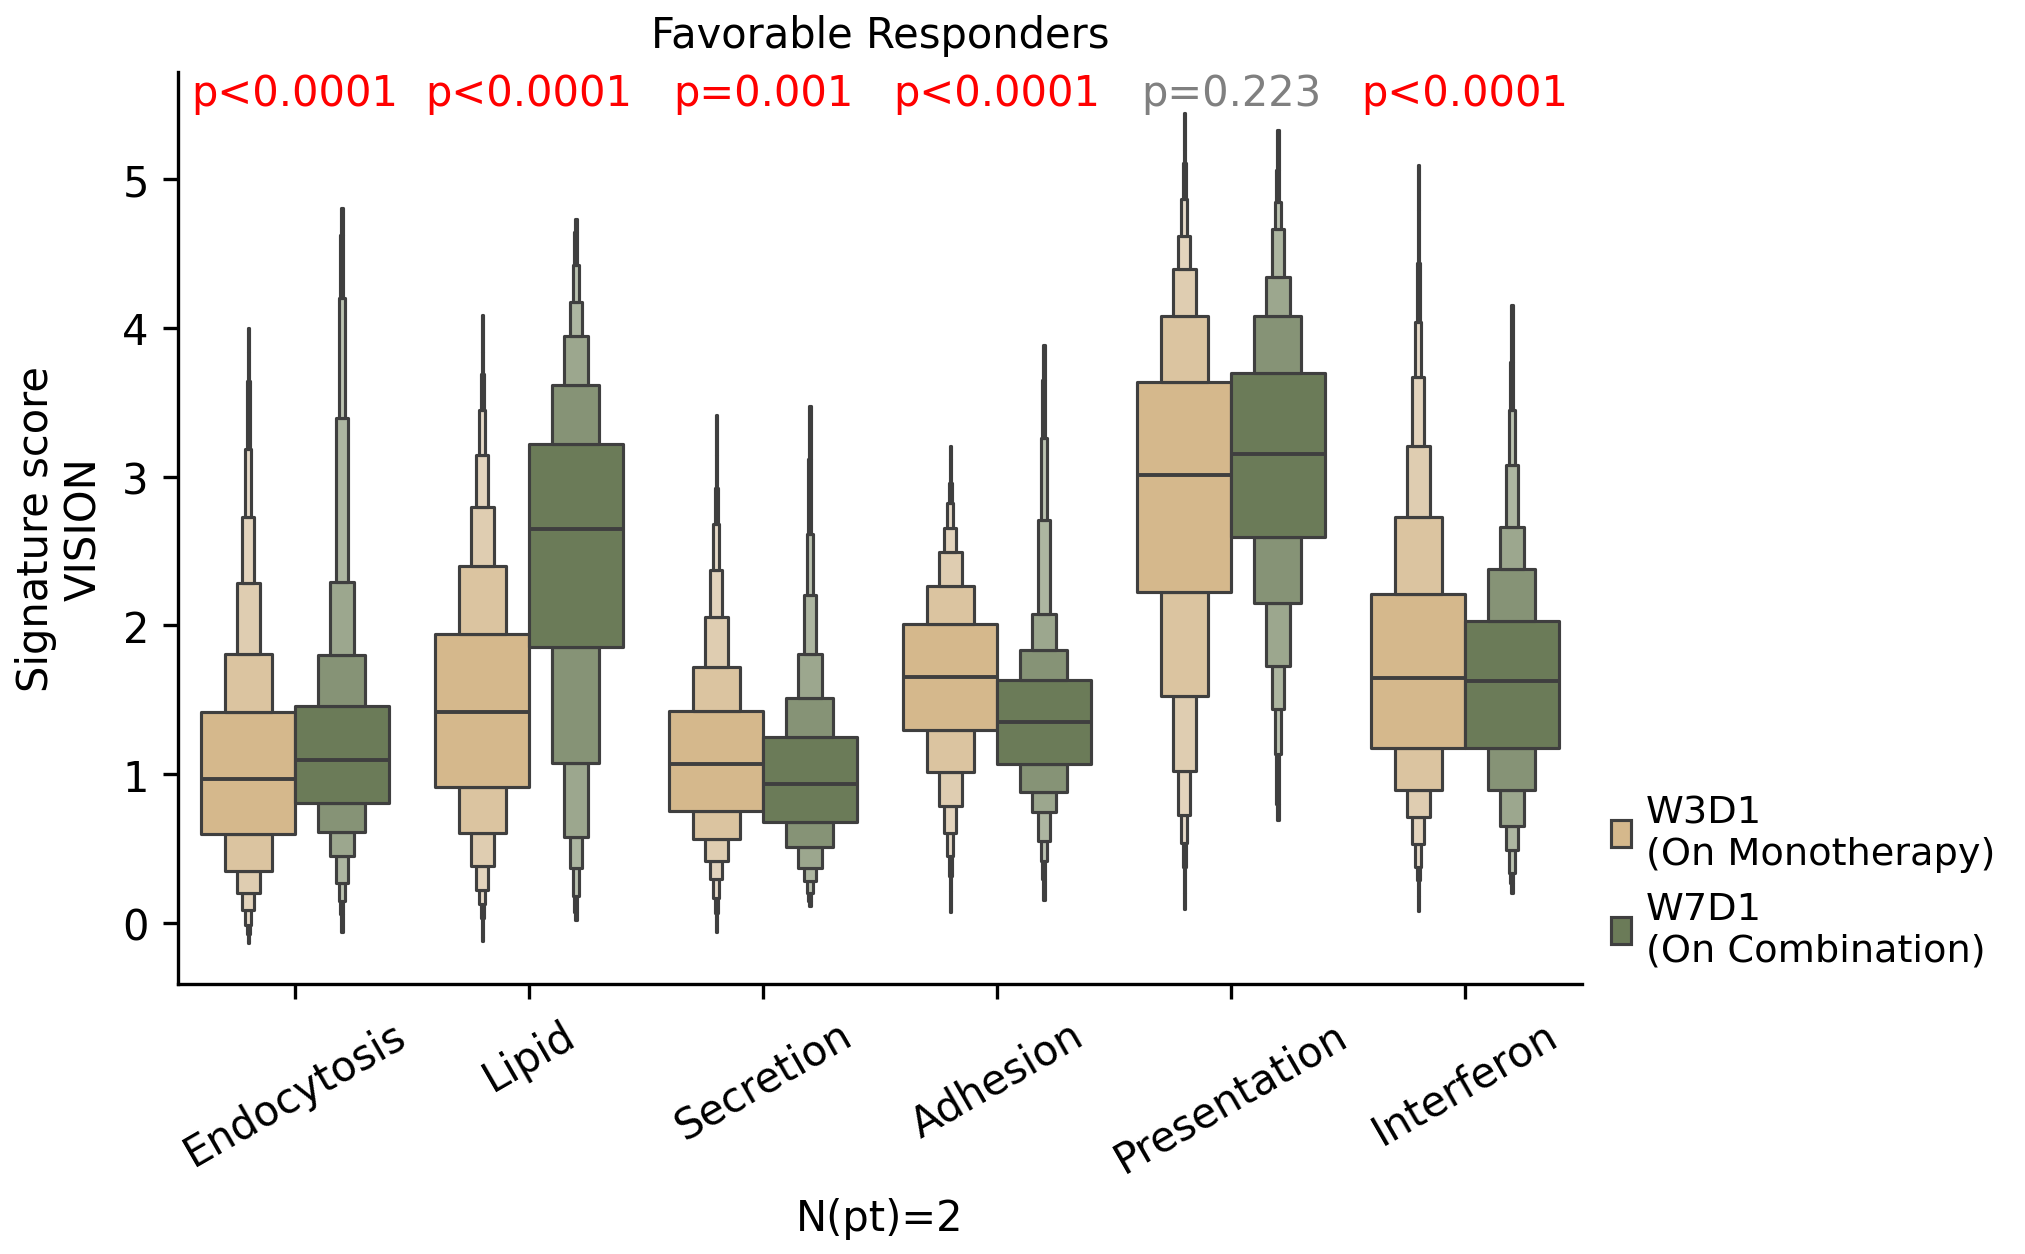

In [83]:
# show_mps = result.loc[(result.Pvalue<0.05)&(result[f'Coef'].abs()>.3),:].sort_values('log2FC').Y.tolist()
# show_mps= ['Adhesion', 'Interferon', 'Lipid']
# show_mps = ['Endocytosis','Presentation']
# show_mps = list(MP_anno_map.values())
show_mps = ['Endocytosis','Lipid','Secretion','Adhesion','Presentation','Interferon']#result.sort_values('Coef').Y.unique().tolist()
pvalues = result.loc[(result.Y.isin(show_mps)),:].set_index('Y')['Pvalue']
dt.rename(columns=MP_anno_map,inplace=True)

plot_rename = {'W3D1':'W3D1\n(On Monotherapy)','W7D1':'W7D1\n(On Combination)'}
dt[x] = dt[x].replace(plot_rename)
palette = {}
for k,v in plot_rename.items():
    palette[v] = COLOR_PAlETTE[x][k]
    
fig,ax=plt.subplots(1,1,figsize=(6,4),dpi=150)
sns.boxenplot(data=dt[show_mps+[x]].melt(id_vars=[x]),
                x='variable',y='value',hue=x,showfliers=False,
                palette=palette,ax=ax)
y_loc =ax.get_ylim()[1]
for xtick in ax.get_xticklabels():
    x_loc,_ = xtick.get_position()
    text = xtick.get_text()
    label = f"p={pvalues[text]:.3f}" if pvalues[text] >= 0.0001 else "p<0.0001"
    if pvalues[text] >= 0.05:
        c='gray'
    else:
        c = 'red'
    ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c)
ax.set(xlabel=f"N(pt)={dt['Patient'].nunique()}",ylabel=f"Signature score\n{signature_method}",title='Favorable Responders')
# ax.set_xticklabels([])
ax.tick_params(axis='x',rotation=30)
ax.legend(loc=(1.01,0),frameon=False,ncol=1)
ax.grid(False)
ax.spines[['right','top']].set_visible(False);

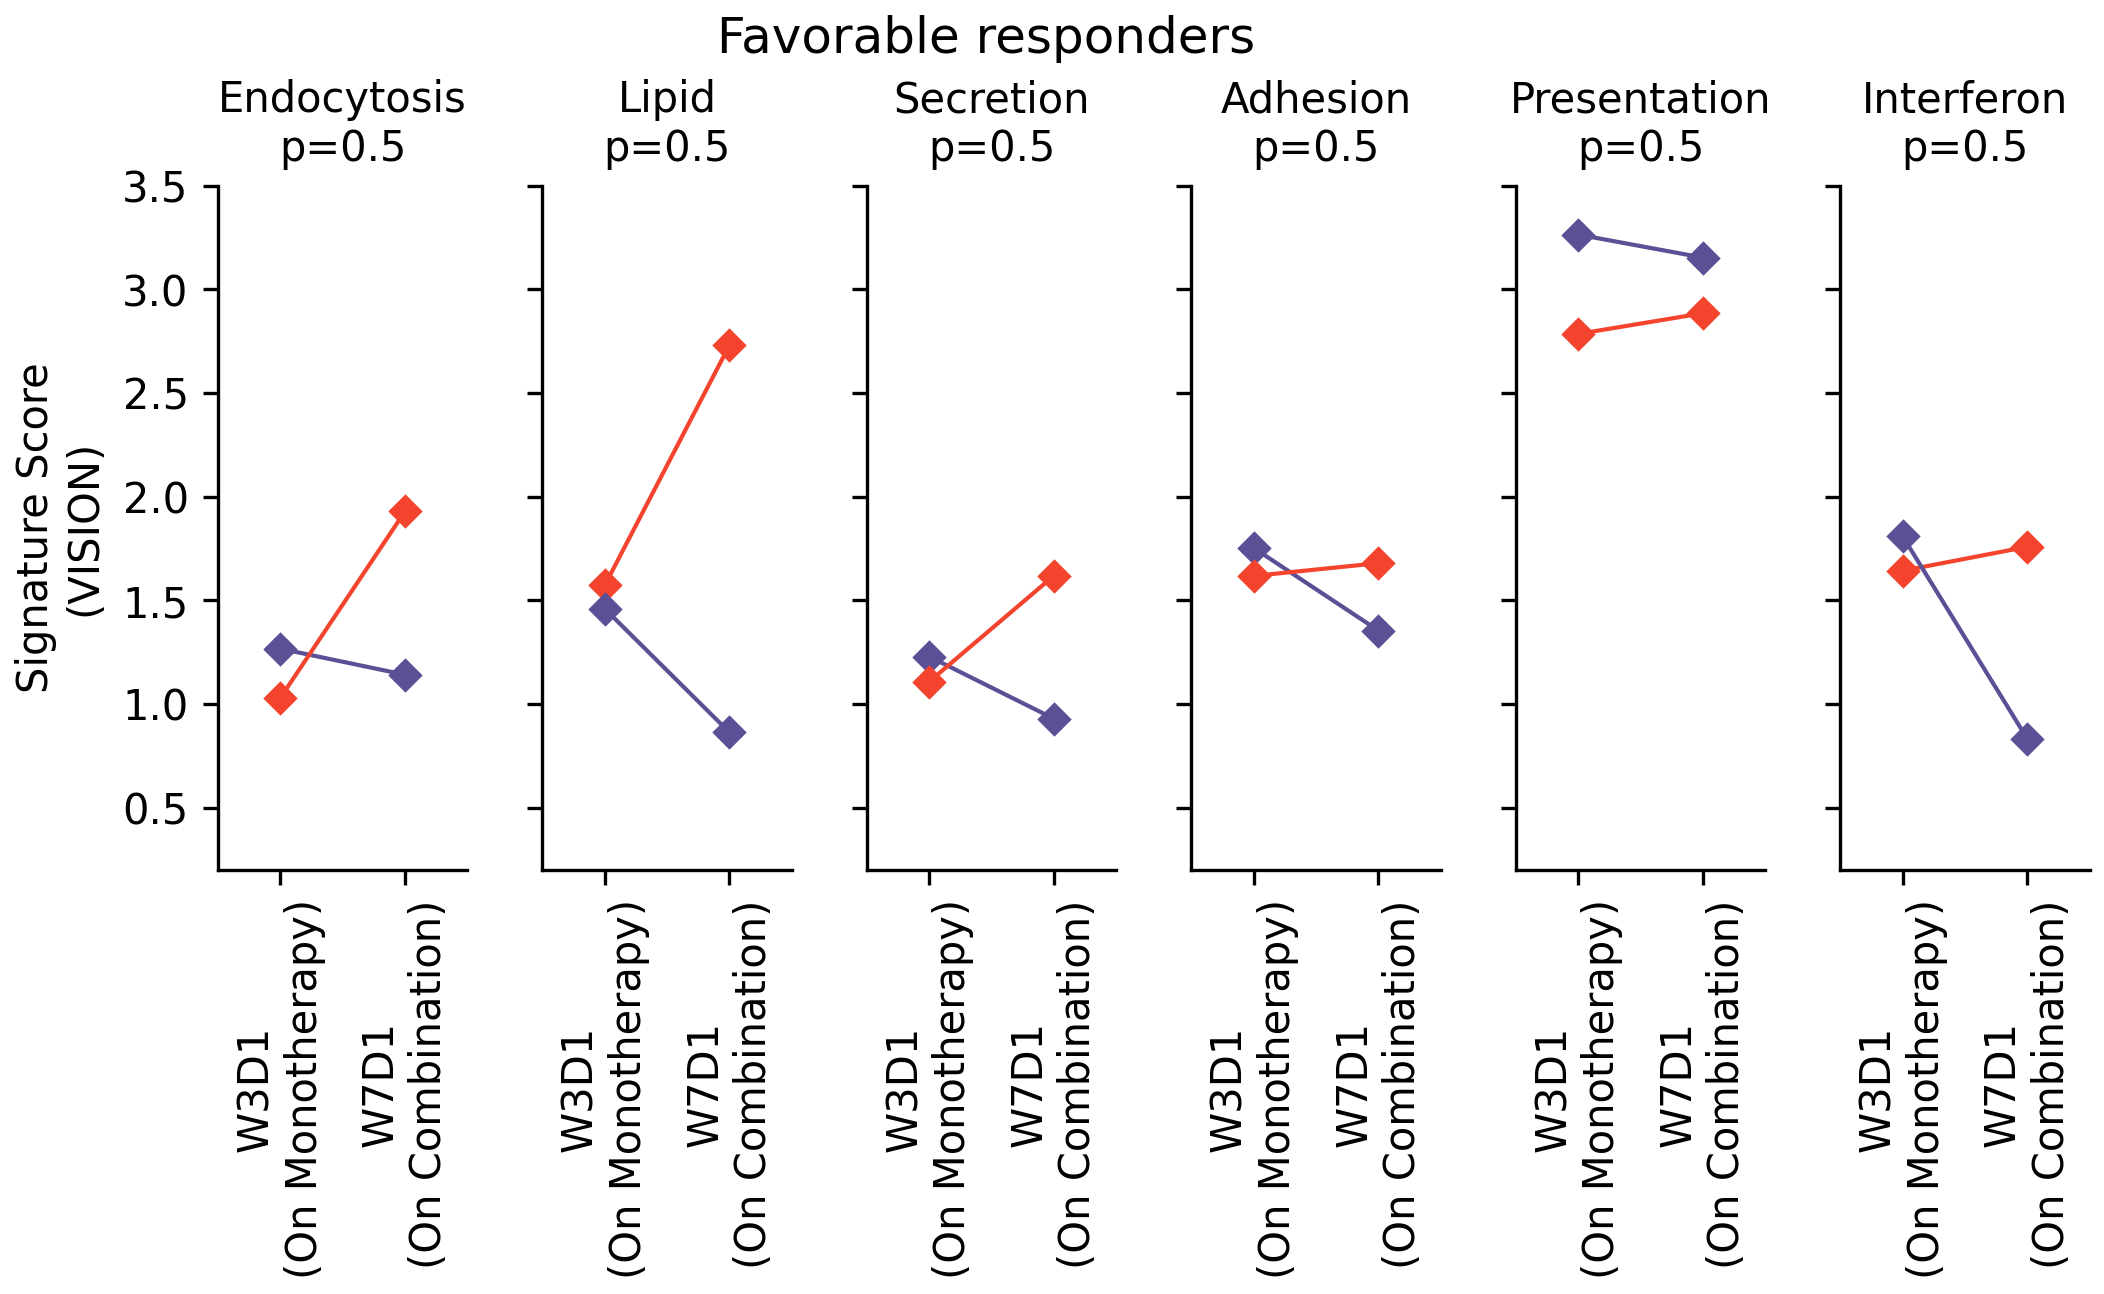

In [84]:
pseudo_dt = dt.groupby(['Patient','Timepoint'])[show_mps].mean().dropna(how='all',axis=0).reset_index()
pseudo_dt.Patient = pseudo_dt.Patient.astype(str)
fig,axs=plt.subplots(1,len(show_mps),figsize=(8,3),dpi=150,sharey=True)
for i,y in enumerate(show_mps):
    ax=axs[i]
    delta = pseudo_dt.pivot_table(index='Patient',columns='Timepoint',values=y).diff(axis=1)['W7D1\n(On Combination)']
    z,p = wilcoxon(delta.values,alternative='greater' if delta.sum()>0 else 'less')
    palette = delta.map(lambda x:"#f4442e" if x >0 else "#5b5095").to_dict()
    # palette = pseudo_dt[['Patient','BestResponse']].drop_duplicates().set_index('Patient')['BestResponse'].map(COLOR_PAlETTE['BestResponse']).to_dict()
    sns.pointplot(data=pseudo_dt,
                   ax=ax,
                  order=['W3D1\n(On Monotherapy)','W7D1\n(On Combination)'],
                  x='Timepoint',y=y,hue='Patient',
                  palette=palette,marker="D",markersize=5,linewidth=1)
    ax.set_ylim([.2,3.5])
    ax.legend_.remove()
    ax.set(xlabel='',ylabel='Signature Score\n(VISION)',title=f"{y}\np={p:.3}")
    ax.tick_params(axis='x',rotation=90)
    ax.grid(False)
plt.subplots_adjust(wspace=.3)
plt.suptitle('Favorable responders',y=1.1);